In [1]:
# install packages
!pip install numpy pandas pyarrow scikit-learn fastcore kagglehub[pandas-datasets] jinja2 boto seaborn fastai

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try 'pacman -S
    python-xyz', where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Arch-packaged Python package,
    create a virtual environment using 'python -m venv path/to/venv'.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-Arch packaged Python application,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. Make sure you have python-pipx
    installed via pacman.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detailed specification.


# Utility methods

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score, get_scorer, get_scorer_names
from fastcore.basics import *
from fastcore.parallel import *
from os import cpu_count
import seaborn as sns
import matplotlib.pyplot as plt
from fastai.tabular.all import df_shrink
import numpy as np


/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
drop_columns = [
    "id",
    "Flow ID",        
    "Source IP", "Src IP",
    "Source Port", "Src Port",
    "Destination IP", "Dst IP",
    "Destination Port", "Dst Port",
    "Timestamp",
    "Attempted Category",
]

def xs_y(df, targ): 
    if not isinstance(targ, list):
        xs = df[df.columns.difference([targ])].copy()
    else:
        xs = df[df.columns.difference(targ)].copy()
    y = df[targ].copy()
    return xs, y

def get_cic_dataset(file):
    df = kagglehub.load_dataset(
          KaggleDatasetAdapter.PANDAS,
          "jozefjankaj/thesis-files",
          "cic/" + file)    
    df.drop(columns=drop_columns, inplace=True, errors='ignore')
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df = df_shrink(df).reset_index(drop=True)

    return df

def get_concap_dataset(file):
    df = kagglehub.load_dataset(
          KaggleDatasetAdapter.PANDAS,
          "jozefjankaj/thesis-files",
          "concap/" + file)
    # clean the dataset
    df.drop(columns=drop_columns, inplace=True, errors='ignore')
    # drop extra columns produced by concap
    df.drop(columns=["category", "subcategory", "label"], inplace=True, errors='ignore')
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df = df_shrink(df).reset_index(drop=True)
    df["Label"] = 1

    return df

def train_verify_one_feature(train_df: pd.DataFrame, test_df: pd.DataFrame, feature: str):
    root = DecisionTreeClassifier(max_depth=1, criterion='gini')
    train_x, train_y = xs_y(train_df, "Label")
    test_x, test_y = xs_y(test_df, "Label")
    root.fit(train_x[feature].array.reshape(-1,1), train_y)

    predictions = root.predict(test_x[feature].array.reshape(-1,1))
    return feature, roc_auc_score(test_y, predictions), accuracy_score(test_y, predictions), precision_score(test_y, predictions), recall_score(test_y, predictions)

def concap_cic_experiment(benign_df: pd.DataFrame, cic: pd.DataFrame, concap: pd.DataFrame):
    # Train on CIC => Predict ConCap
    benign_balance = benign_df.sample(n=cic.shape[0])
    training_df = pd.concat([benign_balance, cic]).sample(frac=1).reset_index(drop=True)
    testing_df = pd.concat([benign_balance, concap]).sample(frac=1).reset_index(drop=True)

    columns = ["Feature", "ROC AUC Score", "Accuracy", "Precision", "Recall"]

    measurements_cic_concap = pd.DataFrame([train_verify_one_feature(training_df, testing_df, feature) for feature in training_df.columns if feature != "Label"],
                                           columns=columns
                                          )

    # Train on ConCap => Predict CIC
    benign_balance = benign.sample(n=cic.shape[0])
    training_df = pd.concat([benign_balance, concap]).sample(frac=1).reset_index(drop=True)
    testing_df = pd.concat([benign_balance, cic]).sample(frac=1).reset_index(drop=True)

    measurements_concap_cic = pd.DataFrame([train_verify_one_feature(training_df, testing_df, feature) for feature in training_df.columns if feature != "Label"],
                                          columns=columns
                                          )    
    return measurements_cic_concap, measurements_concap_cic

def visualize(dataset: pd.DataFrame, features: list, title: str, y_min: float = .8):
    """
    Plot the top performing features according to ROC AUC.
    """    
    dataset = dataset[dataset["Feature"].isin(features)].sort_values("ROC AUC Score", ascending=False)
    df_melted = dataset.melt(id_vars="Feature", var_name="Metric", value_name="Score")
    
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=df_melted, x="Feature", y='Score', hue='Metric')
    plt.ylim(y_min, 1)

    plt.xticks(rotation=45)
    plt.title(title)

    # Add numbers on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='edge', padding=2, fontsize=8)
        
    plt.tight_layout()
    plt.show()

def get_best_features(cic_concap: pd.DataFrame, concap_cic: pd.DataFrame, threshold: float = .9):
    """
    Calculates the top common features based on ROC AUC
    """
    top_cic_concap = cic_concap[cic_concap["ROC AUC Score"] >= threshold]
    top_concap_cic = concap_cic[concap_cic["ROC AUC Score"] >= threshold]

    return set(top_cic_concap["Feature"]).intersection(top_concap_cic["Feature"])

def compute_average(features: list, cic_concap: pd.DataFrame, concap_cic: pd.DataFrame, measure: str = "ROC AUC Score"):
    averages = pd.DataFrame([((cic_concap[cic_concap["Feature"] == feature][measure].values[0] + concap_cic[concap_cic["Feature"] == feature][measure].values[0]) / 2) for feature in features], columns=["Average ROC AUC Score"])
    features = pd.DataFrame(features, columns=["Feature"])
    return pd.concat([features, averages], axis=1).sort_values("Average ROC AUC Score", ascending=False)

# Benign
Benign flows are used for balancing the training and testing sets

In [4]:
benign = get_cic_dataset("monday.csv")
benign["Label"] = 0
benign

/tmp/ipykernel_5027/1591481594.py:21: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,0,119719148,231,0,0,0,0,0,0.000000,0.000000,...,22509459,17,12685486.0,5296658.0,20694308,6499982,-1,-1,0,0
1,17,65511209,6,6,288,288,48,48,48.000000,0.000000,...,1506210,1506210,64004884.0,0.0,64004884,64004884,-1,-1,0,0
2,17,113976922,267,0,20447,0,153,37,76.580521,44.140625,...,10983883,14,25498178.0,18833046.0,48523116,5463561,-1,-1,0,0
3,17,67037196,8,8,384,384,48,48,48.000000,0.000000,...,11034681,11034681,55956316.0,0.0,55956316,55956316,-1,-1,0,0
4,17,68045057,8,8,384,384,48,48,48.000000,0.000000,...,11043596,11043596,56943904.0,0.0,56943904,56943904,-1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350815,6,5571687,4,2,0,187,0,0,0.000000,0.000000,...,108511,108511,5354085.0,0.0,5354085,5354085,-1,-1,5571687,0
350816,6,63255945,8,5,169,123,46,0,21.125000,23.111145,...,223699,223699,58780168.0,0.0,58780167,58780167,-1,-1,183308410,0
350817,17,163,2,2,104,220,52,52,52.000000,0.000000,...,0,0,0.0,0.0,0,0,-1,-1,0,0
350818,6,4476954,8,9,577,4039,342,0,72.125000,136.576965,...,0,0,0.0,0.0,0,0,-1,-1,4476954,0


# Tuesday

In [5]:
tuesday_cic = get_cic_dataset("tuesday.csv")

/tmp/ipykernel_5027/1591481594.py:21: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


## FTP Bruteforce

In [147]:
cic_ftp = tuesday_cic[tuesday_cic["Label"] == "FTP-Patator"].copy()
cic_ftp["Label"] = 1
cic_ftp

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
4597,6,4008190,6,6,30,76,16,0,5.000000,7.771744,...,0,0,0.0,0.0,0,0,-1,-1,4008190,1
4598,6,4018946,6,6,30,76,16,0,5.000000,7.771744,...,0,0,0.0,0.0,0,0,-1,-1,4018946,1
4599,6,4067119,6,6,34,76,20,0,5.666667,8.981462,...,0,0,0.0,0.0,0,0,-1,-1,4067119,1
4600,6,4015015,6,6,30,76,16,0,5.000000,7.771744,...,0,0,0.0,0.0,0,0,-1,-1,4015015,1
4601,6,4099543,6,6,31,76,17,0,5.166667,8.060190,...,0,0,0.0,0.0,0,0,-1,-1,4099543,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306894,6,9567017,11,17,135,188,34,0,12.272727,11.384998,...,0,0,0.0,0.0,0,0,-1,-1,9567017,1
306947,6,8627604,11,17,125,188,25,0,11.363636,9.871907,...,0,0,0.0,0.0,0,0,-1,-1,8627604,1
306980,6,8438103,11,17,116,188,20,0,10.545455,8.721968,...,0,0,0.0,0.0,0,0,-1,-1,8438103,1
307002,6,8958671,11,17,124,188,24,0,11.272727,9.654956,...,0,0,0.0,0.0,0,0,-1,-1,8958671,1


In [148]:
concap_ftp = get_concap_dataset("concap_ftp.csv")
concap_ftp.drop(columns=["label", "category", "subcategory"], inplace=True, errors='ignore')
concap_ftp["Label"] = 1
concap_ftp

/tmp/ipykernel_5027/1591481594.py:34: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,3029650,11,17,88.0,188.0,15.0,0.0,8.000000,6.496153,...,0,0,0,0,0,0,-1,-1,3029650,1
1,6,3034178,11,17,85.0,188.0,14.0,0.0,7.727273,6.198240,...,0,0,0,0,0,0,-1,-1,3034178,1
2,6,3032346,11,17,85.0,188.0,14.0,0.0,7.727273,6.214353,...,0,0,0,0,0,0,-1,-1,3032346,1
3,6,3032433,11,18,88.0,188.0,16.0,0.0,8.000000,6.511528,...,0,0,0,0,0,0,-1,-1,3032433,1
4,6,3027024,11,18,84.0,188.0,14.0,0.0,7.636364,6.152605,...,0,0,0,0,0,0,-1,-1,3027024,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5695,6,3235936,14,18,86.0,188.0,16.0,0.0,6.142857,6.502747,...,0,0,0,0,0,0,-1,-1,3235936,1
5696,6,3032999,11,17,88.0,188.0,17.0,0.0,8.000000,6.618157,...,0,0,0,0,0,0,-1,-1,3032999,1
5697,6,3034066,11,16,79.0,188.0,16.0,0.0,7.181818,5.980270,...,0,0,0,0,0,0,-1,-1,3034066,1
5698,6,3031003,11,17,87.0,188.0,15.0,0.0,7.909091,6.425800,...,0,0,0,0,0,0,-1,-1,3031003,1


In [149]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_ftp, concap_ftp)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [150]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
54,Average Packet Size,0.977757,0.981700,0.970043,0.999825
42,Packet Length Mean,0.977757,0.981700,0.970043,0.999825
41,Packet Length Max,0.977593,0.981596,0.969718,1.000000
64,Subflow Fwd Bytes,0.975831,0.980149,0.967413,1.000000
8,Fwd Packet Length Mean,0.975453,0.979839,0.966921,1.000000
55,Fwd Segment Size Avg,0.975453,0.979839,0.966921,1.000000
56,Bwd Segment Size Avg,0.972306,0.977254,0.962838,1.000000
12,Bwd Packet Length Mean,0.972306,0.977254,0.962838,1.000000
35,Bwd RST Flags,0.971807,0.967535,0.996863,0.947895
10,Bwd Packet Length Max,0.971047,0.976220,0.961214,1.000000


In [151]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
53,Down/Up Ratio,0.992321,0.992321,0.988265,0.996475
35,Bwd RST Flags,0.984517,0.984517,0.974599,0.994965
42,Packet Length Mean,0.977341,0.977341,0.957308,0.999245
54,Average Packet Size,0.977341,0.977341,0.957308,0.999245
41,Packet Length Max,0.973439,0.973439,0.956100,0.992447
64,Subflow Fwd Bytes,0.972810,0.972810,0.952967,0.994713
8,Fwd Packet Length Mean,0.971928,0.971928,0.951360,0.994713
55,Fwd Segment Size Avg,0.971928,0.971928,0.951360,0.994713
56,Bwd Segment Size Avg,0.971803,0.971803,0.946616,1.000000
12,Bwd Packet Length Mean,0.971803,0.971803,0.946616,1.000000


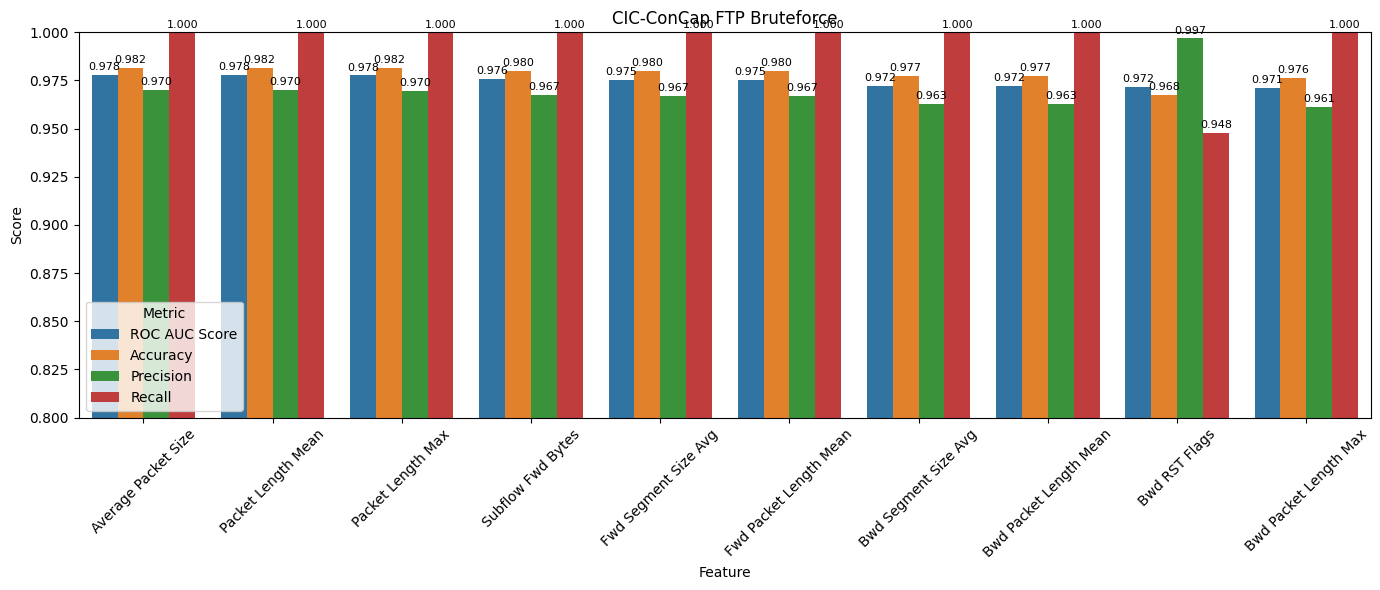

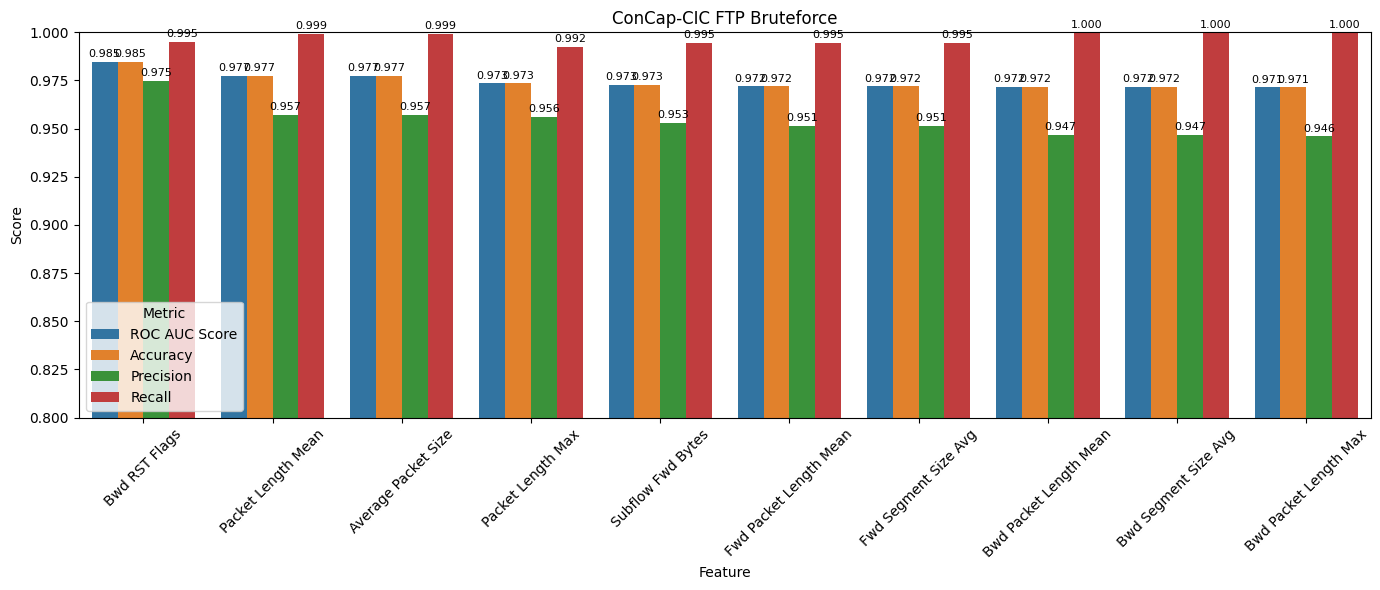

In [152]:
features = get_best_features(cic_concap, concap_cic, .967)
visualize(cic_concap, features, "CIC-ConCap FTP Bruteforce")
visualize(concap_cic, features, "ConCap-CIC FTP Bruteforce")

In [12]:
compute_average(features, cic_concap, concap_cic)

,Feature,Average ROC AUC Score
10,Bwd RST Flags,0.978288
13,Packet Length Mean,0.976290
6,Average Packet Size,0.976290
4,Packet Length Max,0.974572
3,Subflow Fwd Bytes,0.973376
11,Fwd PSH Flags,0.972209
2,Bwd Segment Size Avg,0.971173
14,Bwd Packet Length Mean,0.971173
12,Fwd Segment Size Avg,0.970670
5,Fwd Packet Length Mean,0.970670


## SSH Bruteforce

In [13]:
cic_ssh = tuesday_cic[tuesday_cic["Label"] == "SSH-Patator"].copy()
cic_ssh["Label"] = 1
cic_ssh

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
77364,6,4755497,14,15,1304,2153,640,0,93.142860,174.584717,...,0,0,0.0,0.0,0,0,-1,-1,4755497,1
77365,6,4742052,14,15,1304,2153,640,0,93.142860,174.584717,...,0,0,0.0,0.0,0,0,-1,-1,4742052,1
77366,6,1688206,10,10,1128,2009,640,0,112.800003,203.802078,...,0,0,0.0,0.0,0,0,-1,-1,1688206,1
77367,6,1884425,13,11,1128,2009,640,0,86.769234,183.298553,...,0,0,0.0,0.0,0,0,-1,-1,1884425,1
77368,6,1937542,13,11,1128,2009,640,0,86.769234,183.298553,...,0,0,0.0,0.0,0,0,-1,-1,1937542,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306904,6,11725520,22,33,2024,2745,640,0,92.000000,138.338440,...,0,0,0.0,0.0,0,0,-1,-1,11725520,1
306911,6,11641016,22,33,2024,2745,640,0,92.000000,138.338440,...,0,0,0.0,0.0,0,0,-1,-1,11641016,1
306912,6,12117686,22,33,2008,2745,640,0,91.272728,138.182144,...,0,0,0.0,0.0,0,0,-1,-1,12117686,1
307059,6,13640748,22,33,2008,2745,640,0,91.272728,138.182144,...,0,0,0.0,0.0,0,0,-1,-1,13640748,1


In [14]:
concap_ssh = get_concap_dataset("concap_ssh.csv")
concap_ssh.drop(columns=["label", "category", "subcategory"], inplace=True, errors='ignore')
concap_ssh["Label"] = 1
concap_ssh

/tmp/ipykernel_5027/1591481594.py:34: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,4660,3,3,24.0,0.0,24.0,0.0,8.000000,13.856406,...,0,0,0,0,0,0,-1,-1,4660,1
1,6,3557,3,3,24.0,0.0,24.0,0.0,8.000000,13.856406,...,0,0,0,0,0,0,-1,-1,3557,1
2,6,19511,4,3,24.0,0.0,24.0,0.0,6.000000,12.000000,...,0,0,0,0,0,0,-1,-1,19511,1
3,6,11027649,22,34,1928.0,2746.0,640.0,0.0,87.636360,137.780548,...,0,0,0,0,0,0,-1,-1,11027649,1
4,6,9870,5,4,24.0,0.0,24.0,0.0,4.800000,10.733127,...,0,0,0,0,0,0,-1,-1,9870,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7633,6,4487608,17,17,1272.0,2154.0,640.0,0.0,74.823532,161.218887,...,0,0,0,0,0,0,-1,-1,4487608,1
7634,6,3367832,14,16,1272.0,2154.0,640.0,0.0,90.857140,174.415451,...,0,0,0,0,0,0,-1,-1,3367832,1
7635,6,4025378,17,17,1272.0,2154.0,640.0,0.0,74.823532,161.218887,...,0,0,0,0,0,0,-1,-1,4025378,1
7636,6,3951,4,4,24.0,0.0,24.0,0.0,6.000000,12.000000,...,0,0,0,0,0,0,-1,-1,3951,1


In [15]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_ssh, concap_ssh)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [16]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
70,Fwd Seg Size Min,0.924595,0.957638,0.944919,0.999476
67,FWD Init Win Bytes,0.893110,0.940277,0.923468,1.000000
24,Fwd IAT Min,0.862297,0.861591,0.942239,0.860697
46,SYN Flag Count,0.822357,0.900745,0.878941,1.000000
7,Fwd Packet Length Min,0.800743,0.888669,0.866183,1.000000
40,Packet Length Min,0.799730,0.888103,0.865594,1.000000
11,Bwd Packet Length Min,0.798041,0.887159,0.864614,1.000000
0,Protocol,0.797535,0.886876,0.864320,1.000000
56,Bwd Segment Size Avg,0.794259,0.838192,0.883068,0.893820
12,Bwd Packet Length Mean,0.794259,0.838192,0.883068,0.893820


In [17]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
70,Fwd Seg Size Min,0.919453,0.919453,0.861677,0.999325
24,Fwd IAT Min,0.847518,0.847518,0.802647,0.921648
12,Bwd Packet Length Mean,0.840763,0.840763,0.764968,0.983789
56,Bwd Segment Size Avg,0.840763,0.840763,0.764968,0.983789
45,FIN Flag Count,0.812394,0.812394,0.728282,0.996623
46,SYN Flag Count,0.811888,0.811888,0.726737,0.999662
37,Bwd Header Length,0.811550,0.811550,0.726269,1.000000
30,Fwd PSH Flags,0.808342,0.808342,0.722900,1.000000
9,Fwd Packet Length Std,0.806822,0.806822,0.721315,1.000000
48,PSH Flag Count,0.806484,0.806484,0.720964,1.000000


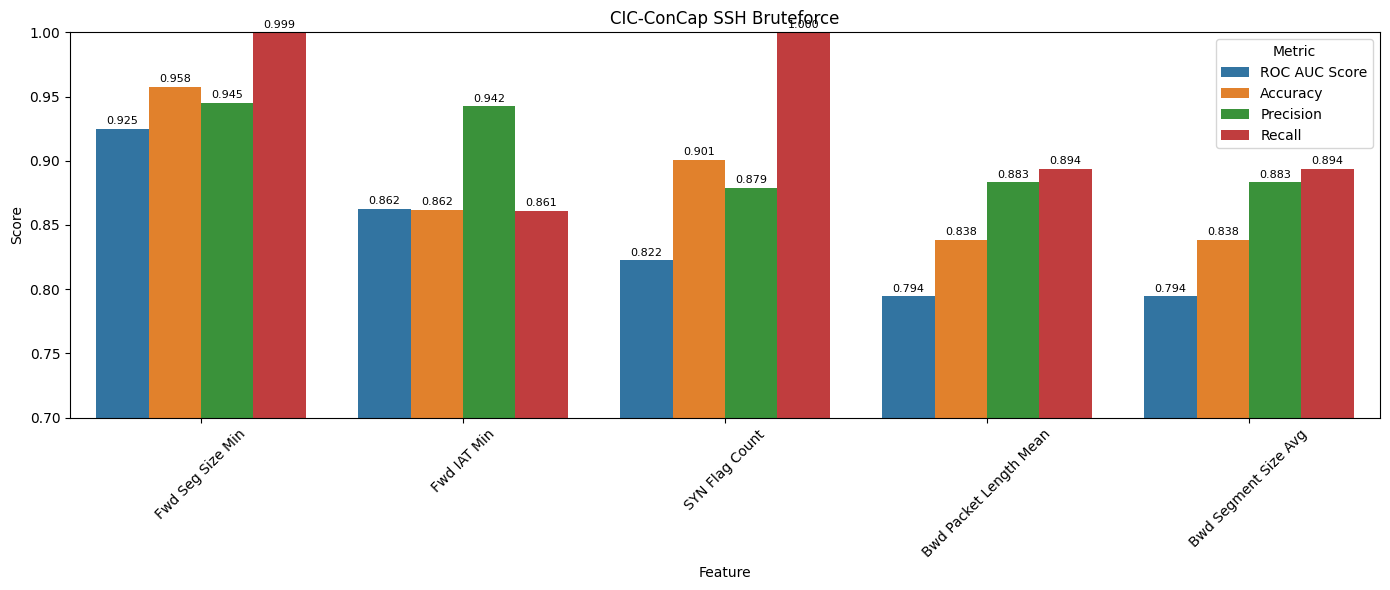

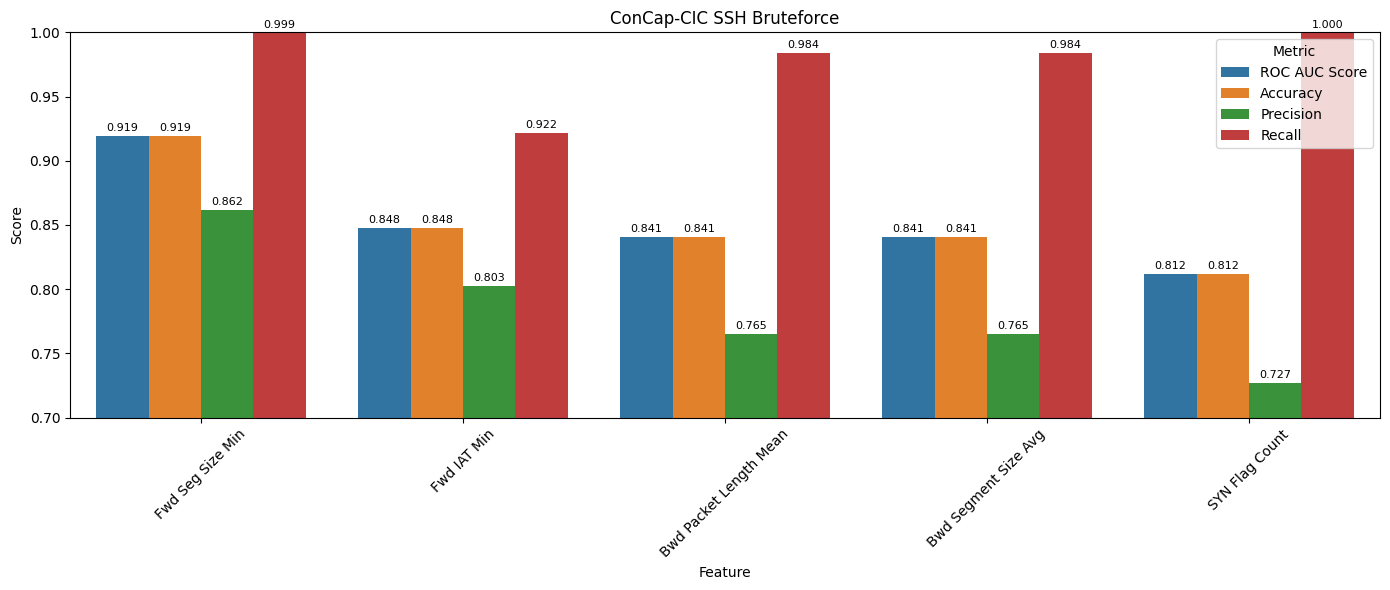

In [18]:
features = get_best_features(cic_concap, concap_cic, .79)
visualize(cic_concap, features, "CIC-ConCap SSH Bruteforce", y_min=.7)
visualize(concap_cic, features, "ConCap-CIC SSH Bruteforce", y_min=.7)

In [19]:
compute_average(features, cic_concap, concap_cic)

,Feature,Average ROC AUC Score
1,Fwd Seg Size Min,0.922024
3,Fwd IAT Min,0.854907
0,Bwd Segment Size Avg,0.817511
4,Bwd Packet Length Mean,0.817511
2,SYN Flag Count,0.817123


# Wednesday

In [20]:
wednesday_cic = get_cic_dataset("wednesday.csv")

/tmp/ipykernel_5027/1591481594.py:21: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [21]:
wednesday_cic["Label"].unique()

['BENIGN', 'DoS Slowloris', 'DoS Slowloris - Attempted', 'DoS Slowhttptest', 'DoS Slowhttptest - Attempted', 'DoS Hulk', 'DoS Hulk - Attempted', 'DoS GoldenEye', 'Heartbleed', 'DoS GoldenEye - Attempted']
Categories (10, object): ['BENIGN', 'DoS GoldenEye', 'DoS GoldenEye - Attempted', 'DoS Hulk', ..., 'DoS Slowhttptest - Attempted', 'DoS Slowloris', 'DoS Slowloris - Attempted', 'Heartbleed']

## Slowloris

In [22]:
cic_slowloris = wednesday_cic[wednesday_cic["Label"] == "DoS Slowloris"].copy()
cic_slowloris["Label"] = 1
cic_slowloris

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
9477,6,17072865,4,3,239,0,231,0,59.750000,114.228935,...,1415,1415,17071390.0,0.0,17071390,17071390,-1,-1,17072865,1
9478,6,17069963,4,3,239,0,231,0,59.750000,114.228935,...,856,856,17069048.0,0.0,17069049,17069049,-1,-1,17069963,1
9479,6,17071303,4,3,239,0,231,0,59.750000,114.228935,...,1002,1002,17070196.0,0.0,17070196,17070196,-1,-1,17071303,1
9480,6,17070583,4,3,239,0,231,0,59.750000,114.228935,...,740,740,17069780.0,0.0,17069779,17069779,-1,-1,17070583,1
9481,6,17069147,4,3,239,0,231,0,59.750000,114.228935,...,942,942,17068164.0,0.0,17068165,17068165,-1,-1,17069147,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30773,6,4603499,11,3,1155,483,231,0,105.000000,120.635818,...,0,0,0.0,0.0,0,0,-1,-1,4603499,1
30805,6,4204862,11,3,1386,483,231,0,126.000000,120.635818,...,0,0,0.0,0.0,0,0,-1,-1,4204862,1
30821,6,3202193,10,3,1386,483,231,0,138.600006,119.287888,...,0,0,0.0,0.0,0,0,-1,-1,3202193,1
30837,6,2599709,10,3,1155,483,231,0,115.500000,121.747688,...,0,0,0.0,0.0,0,0,-1,-1,2599709,1


In [23]:
concap_slowloris = get_concap_dataset("concap_slowloris.csv")
concap_slowloris

/tmp/ipykernel_5027/1591481594.py:34: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,118926264,62,61,725.0,0.0,253.0,0.0,11.693548,31.180904,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118926264,1
1,6,118849273,62,61,725.0,0.0,253.0,0.0,11.693548,31.180904,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118849273,1
2,6,118886942,62,61,725.0,0.0,253.0,0.0,11.693548,31.180904,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118886942,1
3,6,118823677,62,61,725.0,0.0,253.0,0.0,11.693548,31.180904,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118823677,1
4,6,118644621,62,61,725.0,0.0,253.0,0.0,11.693548,31.180904,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118644621,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115,6,64981331,7,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,7124966.0,7124966.0,19285456.0,12963483.0,33536460.0,8193397.0,-1,-1,64981331,1
2116,6,108873650,60,59,685.0,406.0,253.0,0.0,11.416667,31.795050,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,108873650,1
2117,6,64054899,7,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,7221325.0,7221325.0,18944524.0,12403887.0,32514392.0,8190908.0,-1,-1,64054899,1
2118,6,107089854,59,58,677.0,406.0,253.0,0.0,11.474576,32.064781,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,107089854,1


In [24]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_slowloris, concap_slowloris)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [25]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
54,Average Packet Size,0.941725,0.939455,0.887566,0.949528
42,Packet Length Mean,0.941725,0.939455,0.887566,0.949528
14,Flow Bytes/s,0.926176,0.919385,0.842965,0.949528
81,Total TCP Flow Time,0.913021,0.889781,0.765733,0.992925
24,Fwd IAT Min,0.905393,0.895300,0.799759,0.940094
4,Total Length of Fwd Packet,0.800905,0.848637,0.909091,0.636792
6,Fwd Packet Length Max,0.800905,0.848637,0.909091,0.636792
8,Fwd Packet Length Mean,0.798443,0.845459,0.897606,0.636792
55,Fwd Segment Size Avg,0.798443,0.845459,0.897606,0.636792
10,Bwd Packet Length Max,0.797147,0.843787,0.891678,0.636792


In [26]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
10,Bwd Packet Length Max,0.939103,0.939103,0.950306,0.926665
5,Total Length of Bwd Packet,0.939103,0.939103,0.950306,0.926665
12,Bwd Packet Length Mean,0.937289,0.937289,0.946783,0.926665
56,Bwd Segment Size Avg,0.937289,0.937289,0.946783,0.926665
66,Subflow Bwd Bytes,0.936771,0.936771,0.945782,0.926665
81,Total TCP Flow Time,0.908526,0.908526,0.880889,0.944804
77,Idle Max,0.872117,0.872117,0.925608,0.809277
75,Idle Mean,0.871469,0.871469,0.918296,0.815496
38,Fwd Packets/s,0.844908,0.844908,0.838161,0.854885
15,Flow Packets/s,0.837652,0.837652,0.825425,0.856439


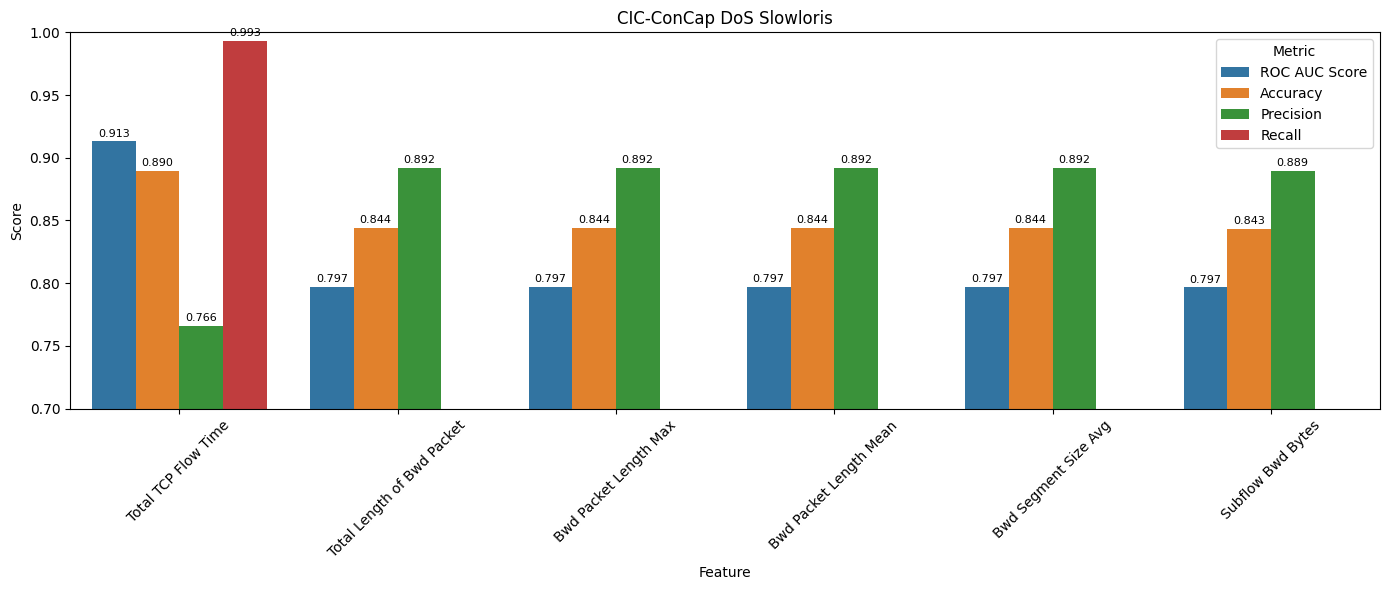

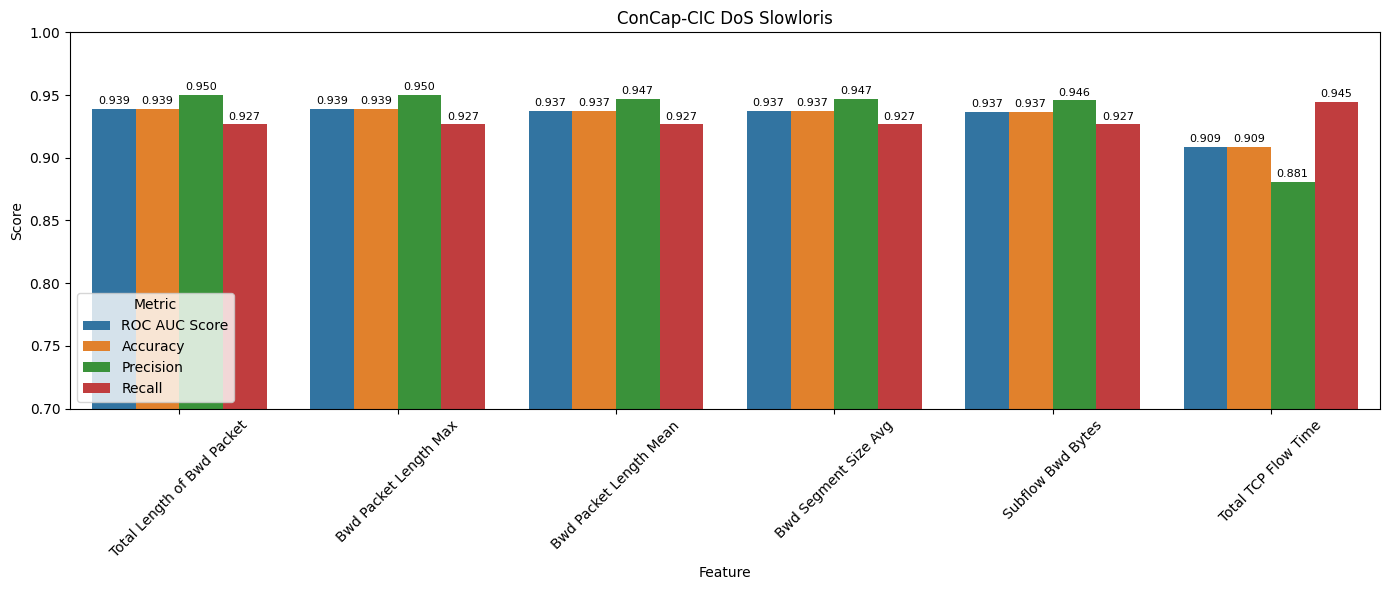

In [27]:
features = get_best_features(cic_concap, concap_cic, .79)
visualize(cic_concap, features, "CIC-ConCap DoS Slowloris", y_min=.7)
visualize(concap_cic, features, "ConCap-CIC DoS Slowloris", y_min=.7)

In [28]:
compute_average(features, cic_concap, concap_cic)

,Feature,Average ROC AUC Score
1,Total TCP Flow Time,0.910773
3,Bwd Packet Length Max,0.868125
4,Total Length of Bwd Packet,0.868125
0,Bwd Segment Size Avg,0.867218
5,Bwd Packet Length Mean,0.867218
2,Subflow Bwd Bytes,0.866700


## Slowhttptest

In [29]:
cic_slowhttptest = wednesday_cic[wednesday_cic["Label"] == "DoS Slowhttptest"].copy()
cic_slowhttptest["Label"] = 1
cic_slowhttptest

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
17741,6,83400021,18,2,5200,0,520,0,288.888885,265.881195,...,7008529,377,11641182.0,6049226.50,20776227,5399131,-1,-1,83400021,1
17742,6,83385834,18,2,5200,0,520,0,288.888885,265.881195,...,7010520,364,11638500.0,6086458.00,20840094,5303271,-1,-1,83385834,1
17758,6,83385227,18,2,5200,0,520,0,288.888885,265.881195,...,7010191,549,11638408.0,6086421.00,20839833,5303148,-1,-1,83385227,1
17759,6,83430584,18,2,5200,0,520,0,288.888885,265.881195,...,7015028,549,11645156.0,6050565.50,20776068,5399130,-1,-1,83430584,1
17767,6,83426649,18,2,5200,0,520,0,288.888885,265.881195,...,7011426,724,11645041.0,6050473.00,20775800,5399051,-1,-1,83426649,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323208,6,31589183,13,2,1683,0,187,0,129.461533,89.831894,...,6533504,6533504,8351745.0,4154461.25,13103822,5407489,-1,-1,31589183,1
351645,6,31521274,13,2,1683,0,187,0,129.461533,89.831894,...,6541345,6541345,8326464.5,4166748.75,13087961,5347461,-1,-1,31521274,1
381314,6,31405313,13,2,1683,0,187,0,129.461533,89.831894,...,6541322,6541322,8287807.0,4223231.00,13103684,5215656,-1,-1,31405313,1
420879,6,31389292,7,2,935,0,187,0,133.571426,91.246658,...,1629605,1629605,29759688.0,0.00,29759687,29759687,-1,-1,31389292,1


In [30]:
concap_slowhttptest = get_concap_dataset("concap_slowhttptest.csv")
concap_slowhttptest

/tmp/ipykernel_5027/1591481594.py:34: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,118697166,62,61,697.0,0.0,461.0,0.0,11.241936,58.060085,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118697166,1
1,6,118535863,62,61,697.0,0.0,461.0,0.0,11.241936,58.060085,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118535863,1
2,6,118513518,62,61,697.0,0.0,461.0,0.0,11.241936,58.060085,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118513518,1
3,6,118493155,62,61,697.0,0.0,461.0,0.0,11.241936,58.060085,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118493155,1
4,6,118374171,62,61,697.0,0.0,461.0,0.0,11.241936,58.060085,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118374171,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108,6,1038645,4,3,4.0,406.0,4.0,0.0,1.000000,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,121389140,1
2109,6,118579235,64,62,697.0,406.0,461.0,0.0,10.890625,57.165070,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118579235,1
2110,6,64665907,7,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,7069661.0,7069661.0,19198748.0,12824313.0,33279304.0,8187769.0,-1,-1,64665907,1
2111,6,113178113,63,61,689.0,406.0,461.0,0.0,10.936508,57.627522,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,113178113,1


In [31]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_slowhttptest, concap_slowhttptest)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [32]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
81,Total TCP Flow Time,0.926623,0.933039,0.896198,0.992901
24,Fwd IAT Min,0.898160,0.901376,0.893327,0.931377
1,Flow Duration,0.895573,0.900597,0.880387,0.947468
20,Fwd IAT Total,0.895573,0.900597,0.880387,0.947468
14,Flow Bytes/s,0.893815,0.899559,0.874891,0.953147
7,Fwd Packet Length Min,0.798851,0.818323,0.751155,1.000000
67,FWD Init Win Bytes,0.798090,0.817545,0.750711,0.999053
70,Fwd Seg Size Min,0.798090,0.817545,0.750711,0.999053
40,Packet Length Min,0.797701,0.817285,0.750089,1.000000
0,Protocol,0.796552,0.816247,0.749025,1.000000


In [33]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
38,Fwd Packets/s,0.894253,0.894253,0.850000,0.957471
15,Flow Packets/s,0.885920,0.885920,0.837607,0.957471
81,Total TCP Flow Time,0.884770,0.884770,0.879320,0.891954
16,Flow IAT Mean,0.883908,0.883908,0.832669,0.960920
21,Fwd IAT Mean,0.882759,0.882759,0.835685,0.952874
39,Bwd Packets/s,0.881322,0.881322,0.827654,0.963218
75,Idle Mean,0.861494,0.861494,0.916556,0.795402
24,Fwd IAT Min,0.853448,0.853448,0.875917,0.823563
22,Fwd IAT Std,0.839655,0.839655,0.771599,0.964943
5,Total Length of Bwd Packet,0.834483,0.834483,0.927313,0.725862


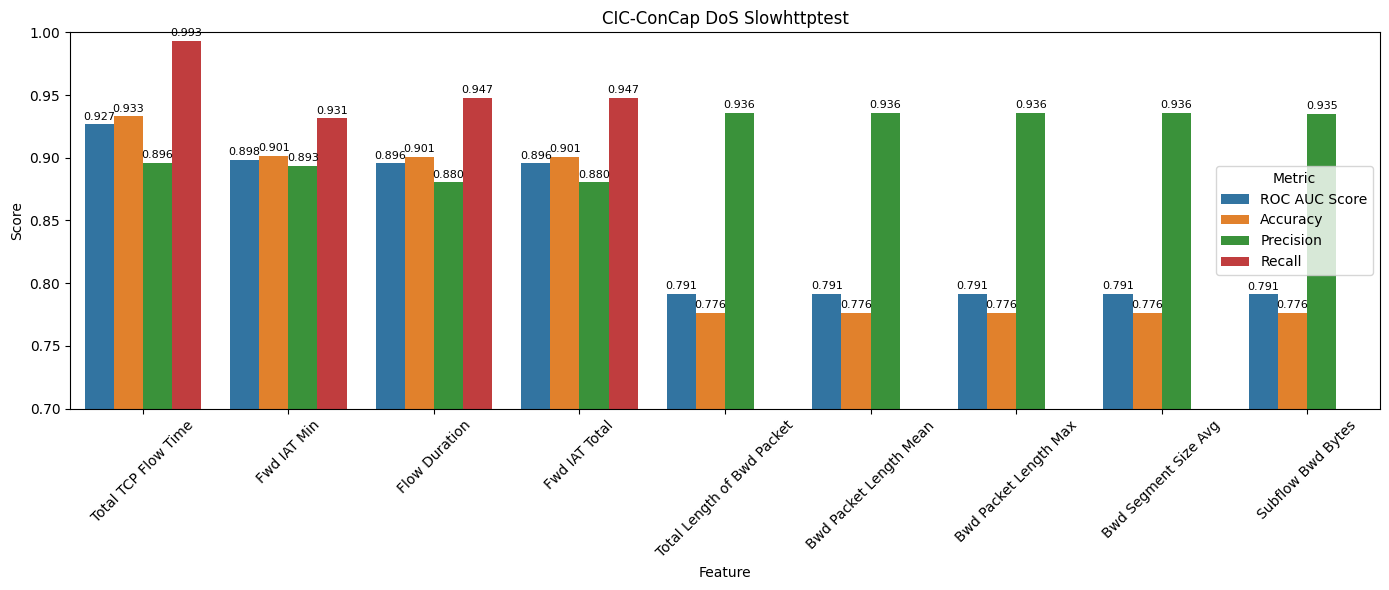

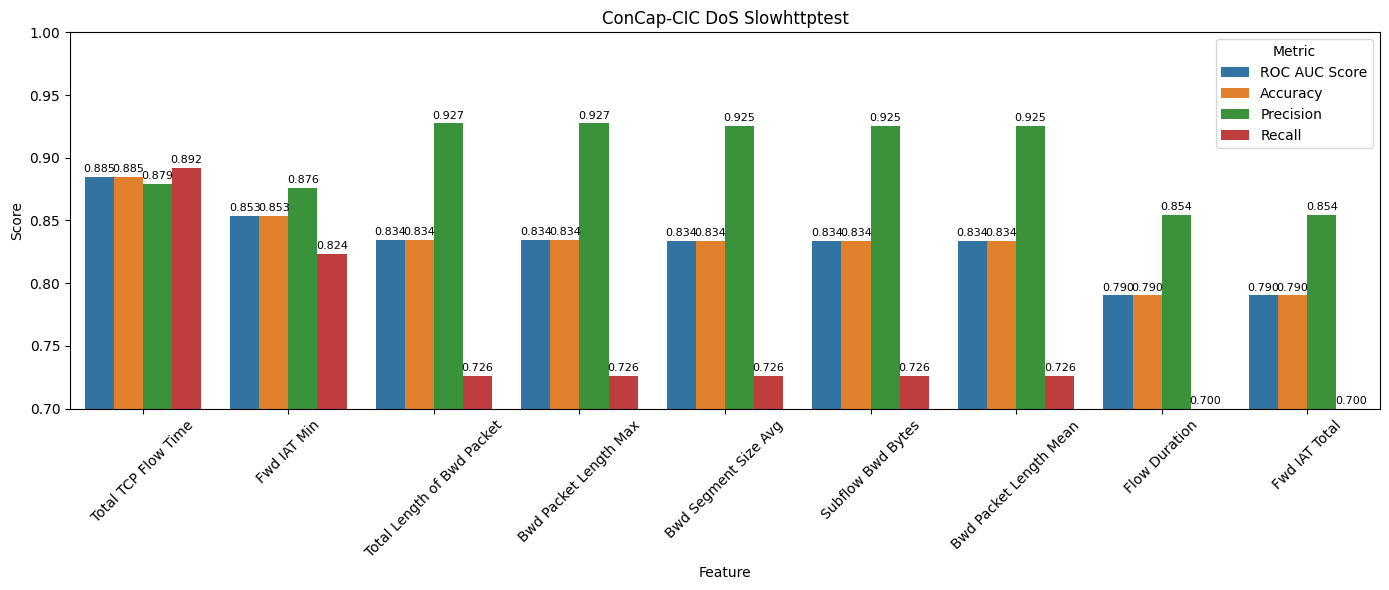

In [34]:
features = get_best_features(cic_concap, concap_cic, .79)
visualize(cic_concap, features, "CIC-ConCap DoS Slowhttptest", y_min=.7)
visualize(concap_cic, features, "ConCap-CIC DoS Slowhttptest", y_min=.7)

In [35]:
compute_average(features, cic_concap, concap_cic)

,Feature,Average ROC AUC Score
2,Total TCP Flow Time,0.905697
5,Fwd IAT Min,0.875804
7,Fwd IAT Total,0.842901
1,Flow Duration,0.842901
6,Total Length of Bwd Packet,0.812920
4,Bwd Packet Length Max,0.812920
0,Bwd Segment Size Avg,0.812489
8,Bwd Packet Length Mean,0.812489
3,Subflow Bwd Bytes,0.812346


## Hulk

In [36]:
cic_hulk = wednesday_cic[wednesday_cic["Label"] == "DoS Hulk"].copy()
cic_hulk["Label"] = 1
cic_hulk

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
33083,6,28504,9,9,348,11595,348,0,38.666668,116.000000,...,0,0,0.0,0.0,0,0,-1,-1,28504,1
33084,6,3466,6,6,382,11595,382,0,63.666668,155.950851,...,0,0,0.0,0.0,0,0,-1,-1,3466,1
33085,6,4212,6,6,372,11595,372,0,62.000000,151.868362,...,0,0,0.0,0.0,0,0,-1,-1,4212,1
33086,6,12080,7,7,349,11595,349,0,49.857143,131.909607,...,0,0,0.0,0.0,0,0,-1,-1,12080,1
33087,6,12005,6,5,371,11595,371,0,61.833332,151.460114,...,0,0,0.0,0.0,0,0,-1,-1,12005,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477865,6,173006,7,7,343,11595,343,0,49.000000,129.641815,...,0,0,0.0,0.0,0,0,-1,-1,173006,1
477872,6,179441,8,4,346,11595,346,0,43.250000,122.329475,...,0,0,0.0,0.0,0,0,-1,-1,179441,1
477902,6,189968,8,8,353,11595,353,0,44.125000,124.804344,...,0,0,0.0,0.0,0,0,-1,-1,189968,1
477908,6,656477,11,5,1041,11595,347,0,94.636360,162.083481,...,0,0,0.0,0.0,0,0,-1,-1,656477,1


In [37]:
concap_hulk = get_concap_dataset("concap_hulk.csv")
concap_hulk

/tmp/ipykernel_5027/1591481594.py:34: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,3070,7,5,366.0,11611.0,366.0,0.0,52.285713,138.334991,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,3070,1
1,6,6535,7,5,336.0,11611.0,336.0,0.0,48.000000,126.996063,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,6535,1
2,6,7113,7,5,361.0,11611.0,361.0,0.0,51.571430,136.445175,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,7113,1
3,6,6639,7,6,317.0,11611.0,317.0,0.0,45.285713,119.814735,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,6639,1
4,6,7900,7,8,367.0,11611.0,367.0,0.0,52.428570,138.712967,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,7900,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172334,6,1529068,10,11,373.0,11611.0,373.0,0.0,37.299999,117.952957,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,1529068,1
172335,6,309216,7,6,363.0,11611.0,363.0,0.0,51.857143,137.201111,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,309216,1
172336,6,378797,9,7,307.0,11611.0,307.0,0.0,34.111111,102.333336,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,378797,1
172337,6,521034,10,7,638.0,11611.0,319.0,0.0,63.799999,134.502213,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,521034,1


In [38]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_hulk, concap_hulk)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [39]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
13,Bwd Packet Length Std,0.957247,0.955518,0.998488,0.916003
34,Fwd RST Flags,0.954124,0.955971,0.923500,0.998172
47,RST Flag Count,0.944794,0.947036,0.909022,0.998242
44,Packet Length Variance,0.941324,0.939040,0.995648,0.886863
43,Packet Length Std,0.941324,0.939040,0.995648,0.886863
66,Subflow Bwd Bytes,0.928386,0.926564,0.971550,0.884953
42,Packet Length Mean,0.926826,0.925113,0.967531,0.885986
54,Average Packet Size,0.926826,0.925113,0.967531,0.885986
5,Total Length of Bwd Packet,0.922907,0.921939,0.947689,0.899831
12,Bwd Packet Length Mean,0.911887,0.908747,0.985671,0.837007


In [40]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
13,Bwd Packet Length Std,0.998637,0.998637,0.998385,0.998889
12,Bwd Packet Length Mean,0.979280,0.979280,0.960353,0.999836
56,Bwd Segment Size Avg,0.979280,0.979280,0.960353,0.999836
10,Bwd Packet Length Max,0.976860,0.976860,0.955910,0.999836
66,Subflow Bwd Bytes,0.974582,0.974582,0.951764,0.999836
41,Packet Length Max,0.973424,0.973424,0.949670,0.999836
5,Total Length of Bwd Packet,0.972663,0.972663,0.948300,0.999836
42,Packet Length Mean,0.972162,0.972162,0.947399,0.999836
54,Average Packet Size,0.972162,0.972162,0.947399,0.999836
44,Packet Length Variance,0.955792,0.955792,0.918893,0.999836


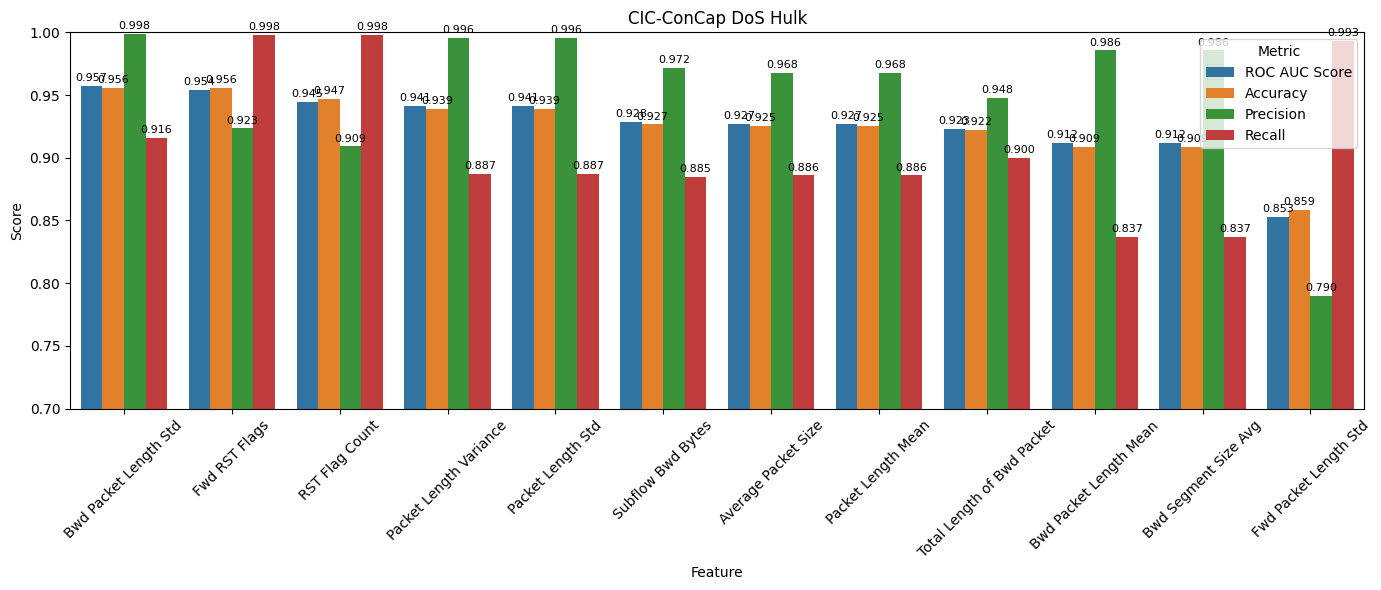

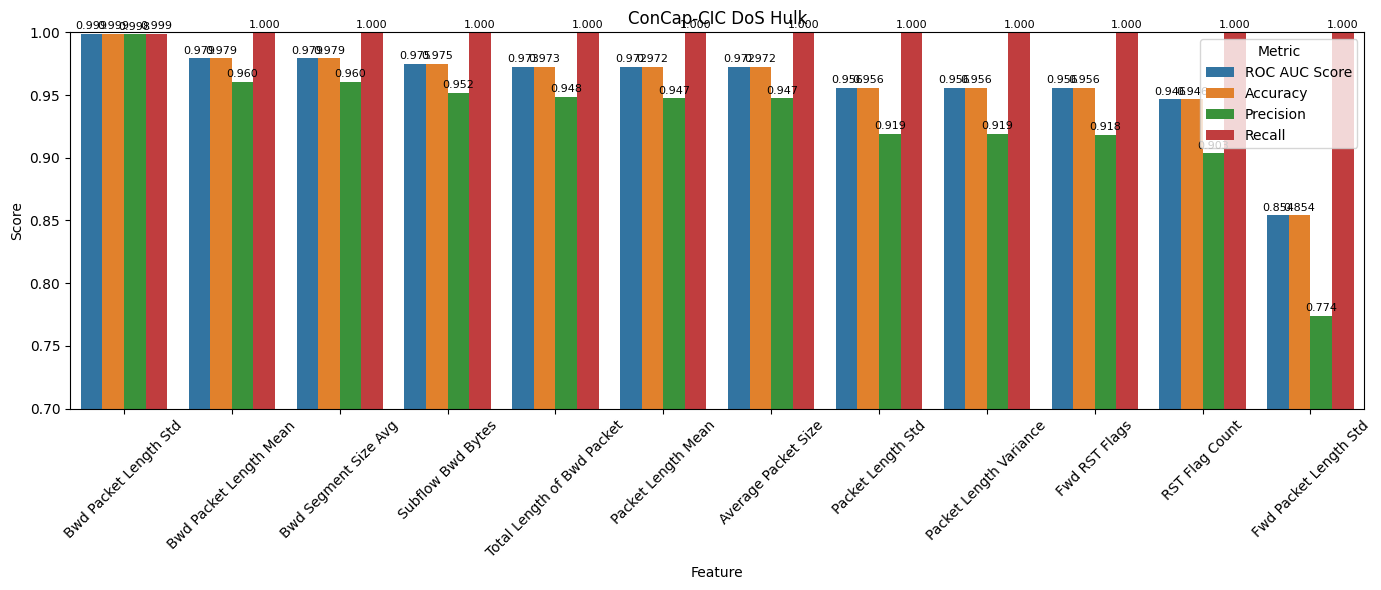

In [41]:
features = get_best_features(cic_concap, concap_cic, .85)
visualize(cic_concap, features, "CIC-ConCap DoS Hulk", y_min=.7)
visualize(concap_cic, features, "ConCap-CIC DoS Hulk", y_min=.7)

In [42]:
compute_average(features, cic_concap, concap_cic)

,Feature,Average ROC AUC Score
2,Bwd Packet Length Std,0.977942
3,Fwd RST Flags,0.954837
8,Subflow Bwd Bytes,0.951484
6,Average Packet Size,0.949494
10,Packet Length Mean,0.949494
4,Packet Length Std,0.948558
5,Packet Length Variance,0.948558
9,Total Length of Bwd Packet,0.947785
1,RST Flag Count,0.945646
0,Bwd Segment Size Avg,0.945583


## GoldenEye

In [43]:
cic_goldeneye = wednesday_cic[wednesday_cic["Label"] == "DoS GoldenEye"].copy()
cic_goldeneye["Label"] = 1
cic_goldeneye

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
188427,6,11454901,9,4,1776,3525,444,0,197.333328,234.008545,...,827250,1474,5293676.0,4.105236e+05,5583960,5003392,-1,-1,11454901,1
188428,6,17437659,12,6,327,11632,327,0,27.250000,94.396767,...,7015689,7015689,5381199.0,0.000000e+00,5381199,5381199,-1,-1,17437659,1
188429,6,10753804,8,6,361,11632,361,0,45.125000,127.632774,...,4287,1108,5355279.5,5.017255e+05,5710053,5000506,-1,-1,10753804,1
188430,6,10752381,8,5,377,11632,377,0,47.125000,133.289627,...,1351,1351,5710766.0,0.000000e+00,5710766,5710766,-1,-1,10752381,1
188431,6,11422331,9,5,487,11632,487,0,54.111111,162.333328,...,1647,712,5690607.5,9.735835e+05,6379035,5002180,-1,-1,11422331,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477888,6,9726755,9,5,300,11632,300,0,33.333332,100.000000,...,4685619,4685619,5001471.0,0.000000e+00,5001471,5001471,-1,-1,201163062,1
477898,6,11509160,6,5,332,3525,332,0,55.333332,135.538437,...,1887,1887,6467018.0,0.000000e+00,6467018,6467018,-1,-1,11509160,1
477941,6,103680007,13,6,1472,11632,368,0,113.230766,176.781479,...,829021,3207,34269688.0,5.022459e+07,92263198,5000791,-1,-1,103680007,1
477943,6,11464350,9,5,588,11632,588,0,65.333336,196.000000,...,749,749,6423318.0,0.000000e+00,6423318,6423318,-1,-1,11464350,1


In [44]:
concap_goldeneye = get_concap_dataset("concap_goldeneye.csv")
concap_goldeneye

/tmp/ipykernel_5027/1591481594.py:34: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,13783803,10,11,1200.0,11610.0,300.0,0.0,120.000000,154.919327,...,853356.0,853356.0,12899901.0,0.0,12899901.0,12899901.0,-1,-1,13783803,1
1,6,56835564,9,6,500.0,11610.0,500.0,0.0,55.555557,166.666672,...,5046952.0,4878.0,25891868.0,17348666.0,38159228.0,13624507.0,-1,-1,56835564,1
2,6,25057619,9,7,404.0,11610.0,404.0,0.0,44.888889,134.666672,...,5047163.0,1704.0,10004376.0,7025186.5,14971933.0,5036819.0,-1,-1,25057619,1
3,6,38433193,10,6,512.0,11610.0,512.0,0.0,51.200001,161.908615,...,5045362.0,6431.0,16690700.0,4830813.5,20106600.0,13274799.0,-1,-1,38433193,1
4,6,5703764,9,8,328.0,11610.0,328.0,0.0,36.444443,109.333336,...,843.0,843.0,5562874.0,0.0,5562874.0,5562874.0,-1,-1,5703764,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4647,6,35282270,11,7,414.0,11610.0,414.0,0.0,37.636364,124.825699,...,1015225.0,1608.0,11406785.0,5741701.5,16095574.0,5003009.0,-1,-1,35282270,1
4648,6,75378643,8,6,509.0,11610.0,509.0,0.0,63.625000,179.958679,...,44432.0,2646.0,25108784.0,27336608.0,56235376.0,5002188.0,-1,-1,75378643,1
4649,6,97824485,15,12,2440.0,11610.0,610.0,0.0,162.666672,279.220001,...,5046710.0,854857.0,45961460.0,45605476.0,78209400.0,13713517.0,-1,-1,97824485,1
4650,6,88655311,9,6,363.0,11610.0,363.0,0.0,40.333332,121.000000,...,45612.0,3088.0,29534088.0,35480576.0,70216728.0,5001881.0,-1,-1,88655311,1


In [45]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_goldeneye, concap_goldeneye)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [46]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
12,Bwd Packet Length Mean,0.972273,0.965709,0.917538,0.999785
56,Bwd Segment Size Avg,0.972273,0.965709,0.917538,0.999785
66,Subflow Bwd Bytes,0.960883,0.951551,0.887109,1.000000
34,Fwd RST Flags,0.956588,0.946231,0.876248,1.000000
42,Packet Length Mean,0.956257,0.945822,0.875423,1.000000
54,Average Packet Size,0.956257,0.945822,0.875423,1.000000
47,RST Flag Count,0.947073,0.934446,0.853108,1.000000
13,Bwd Packet Length Std,0.918151,0.932728,0.962114,0.857051
5,Total Length of Bwd Packet,0.904321,0.881496,0.762623,1.000000
43,Packet Length Std,0.899848,0.910058,0.901832,0.857051


In [47]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
13,Bwd Packet Length Std,0.960420,0.960420,0.998997,0.921766
43,Packet Length Std,0.956059,0.956059,0.922089,0.996300
44,Packet Length Variance,0.956059,0.956059,0.922089,0.996300
70,Fwd Seg Size Min,0.919651,0.919651,0.863288,0.997225
81,Total TCP Flow Time,0.870953,0.870953,0.828227,0.936038
27,Bwd IAT Std,0.867517,0.867517,0.842572,0.903925
20,Fwd IAT Total,0.863222,0.863222,0.818003,0.934320
1,Flow Duration,0.862165,0.862165,0.816638,0.934056
26,Bwd IAT Mean,0.861041,0.861041,0.821412,0.922691
74,Active Min,0.858993,0.858993,0.797048,0.963262


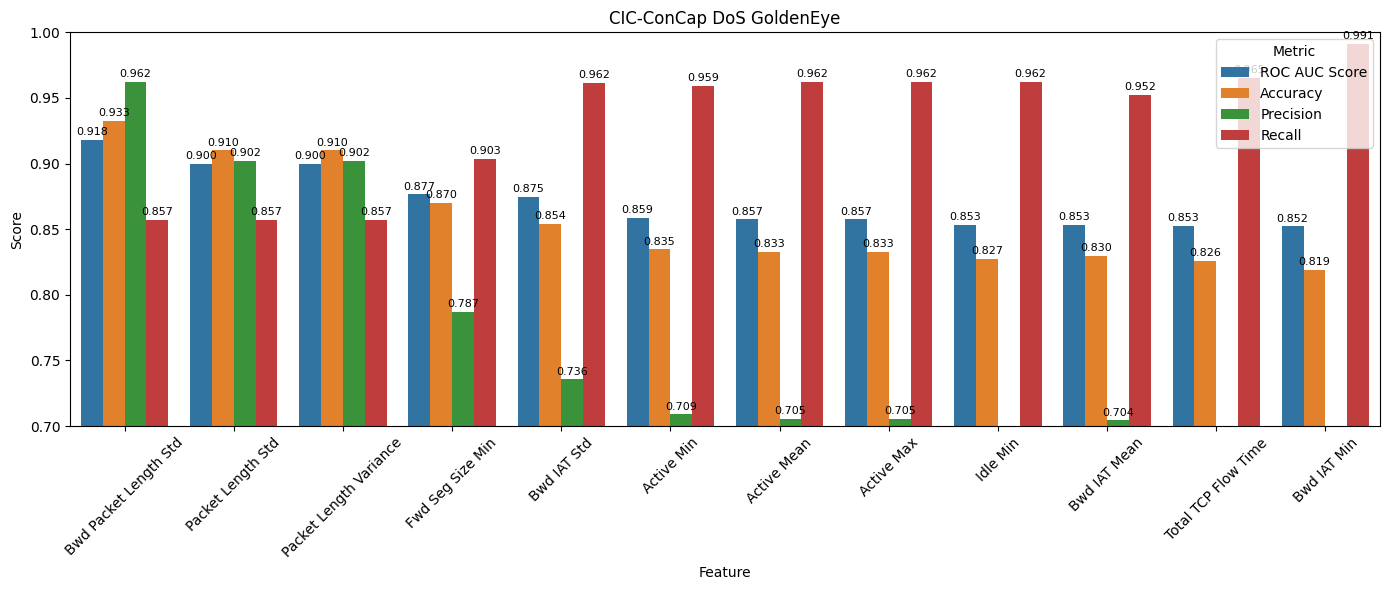

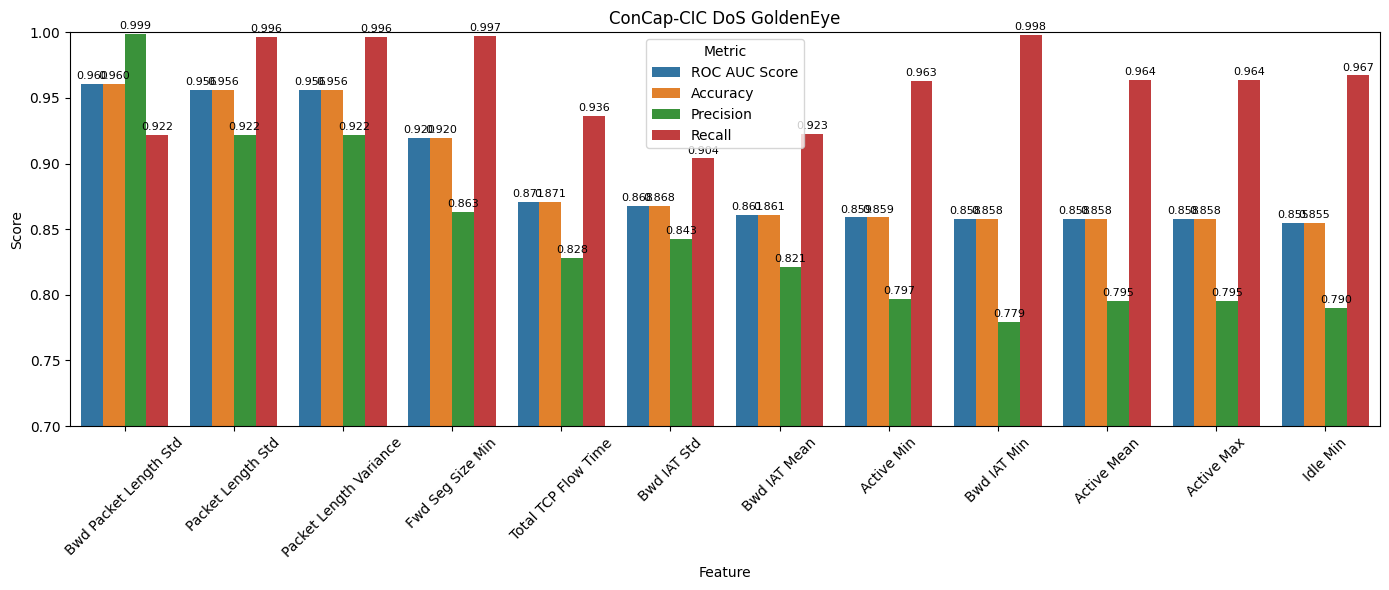

In [48]:
features = get_best_features(cic_concap, concap_cic, .85)
visualize(cic_concap, features, "CIC-ConCap DoS GoldenEye", y_min=.7)
visualize(concap_cic, features, "ConCap-CIC DoS GoldenEye", y_min=.7)

In [49]:
compute_average(features, cic_concap, concap_cic)

,Feature,Average ROC AUC Score
4,Bwd Packet Length Std,0.939286
6,Packet Length Variance,0.927954
11,Packet Length Std,0.927954
8,Fwd Seg Size Min,0.898111
3,Bwd IAT Std,0.871013
7,Total TCP Flow Time,0.861850
9,Active Min,0.858781
0,Active Max,0.857575
10,Active Mean,0.857575
1,Bwd IAT Mean,0.857119


## Heartbleed

In [50]:
cic_heartbleed = wednesday_cic[wednesday_cic["Label"] == "Heartbleed"].copy()
cic_heartbleed["Label"] = 1
cic_heartbleed

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
241579,6,119302728,2685,1729,8299,7556917,517,0,3.090875,16.858421,...,2217,2217,5024984.0,0.0,5024984,5024984,-1,-1,119302728,1
242381,6,119262215,2791,2111,7920,7883927,66,0,2.837692,13.390275,...,0,0,0.0,0.0,0,0,-1,-1,239559056,1
243502,6,119261118,2793,2131,7920,7883880,66,0,2.835661,13.385694,...,0,0,0.0,0.0,0,0,-1,-1,359814372,1
244384,6,119260295,2790,2115,7920,7883880,66,0,2.838710,13.392567,...,0,0,0.0,0.0,0,0,-1,-1,480068718,1
245420,6,119297996,2781,2090,7920,7883880,66,0,2.847896,13.413253,...,0,0,0.0,0.0,0,0,-1,-1,600361033,1
245723,6,119259886,2781,2092,7920,7883880,66,0,2.847896,13.413253,...,0,0,0.0,0.0,0,0,-1,-1,720578677,1
246427,6,119259012,2800,2070,7920,7883880,66,0,2.828571,13.369695,...,0,0,0.0,0.0,0,0,-1,-1,840832907,1
246792,6,119257653,2801,2068,15066,7818181,1486,0,5.378793,62.757992,...,0,0,0.0,0.0,0,0,-1,-1,961085290,1
247611,6,119299621,2804,2029,7920,7884419,66,0,2.824536,13.360579,...,0,0,0.0,0.0,0,0,-1,-1,1081380819,1
247918,6,119296592,2796,2007,7920,7883880,66,0,2.832618,13.378830,...,0,0,0.0,0.0,0,0,-1,-1,1201633329,1


In [51]:
concap_heartbleed = get_concap_dataset("concap_heartbleed.csv")
concap_heartbleed

/tmp/ipykernel_5027/1591481594.py:34: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,17099,7,8,815.0,7759.0,517.0,0.0,116.428574,190.551712,...,0,0,0,0,0,0,-1,-1,17099,1
1,6,1014038,16,12,709.0,67223.0,517.0,0.0,44.312500,130.665848,...,0,0,0,0,0,0,-1,-1,1014038,1
2,6,1012724,16,12,709.0,67223.0,517.0,0.0,44.312500,130.665848,...,0,0,0,0,0,0,-1,-1,1012724,1
3,6,15288,8,9,815.0,7759.0,517.0,0.0,101.875000,181.155365,...,0,0,0,0,0,0,-1,-1,15288,1
4,6,1012355,20,13,709.0,67223.0,517.0,0.0,35.450001,117.515274,...,0,0,0,0,0,0,-1,-1,1012355,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,6,1014955,19,13,709.0,67223.0,517.0,0.0,37.315788,120.430733,...,0,0,0,0,0,0,-1,-1,1014955,1
110,6,1014035,20,13,709.0,67223.0,517.0,0.0,35.450001,117.515274,...,0,0,0,0,0,0,-1,-1,1014035,1
111,6,1010372,15,13,709.0,67223.0,517.0,0.0,47.266666,134.697800,...,0,0,0,0,0,0,-1,-1,1010372,1
112,6,12340,8,9,815.0,7759.0,517.0,0.0,101.875000,181.155365,...,0,0,0,0,0,0,-1,-1,12340,1


In [52]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_heartbleed, concap_heartbleed)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [53]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
13,Bwd Packet Length Std,1.000000,1.000,1.000000,1.000000
14,Flow Bytes/s,0.954545,0.992,0.991304,1.000000
43,Packet Length Std,0.811404,0.656,1.000000,0.622807
10,Bwd Packet Length Max,0.750000,0.544,1.000000,0.500000
62,Bwd Bulk Rate Avg,0.750000,0.544,1.000000,0.500000
12,Bwd Packet Length Mean,0.750000,0.544,1.000000,0.500000
42,Packet Length Mean,0.750000,0.544,1.000000,0.500000
41,Packet Length Max,0.750000,0.544,1.000000,0.500000
44,Packet Length Variance,0.750000,0.544,1.000000,0.500000
60,Bwd Bytes/Bulk Avg,0.750000,0.544,1.000000,0.500000


In [54]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
4,Total Length of Fwd Packet,1.0,1.0,1.0,1.0
5,Total Length of Bwd Packet,1.0,1.0,1.0,1.0
13,Bwd Packet Length Std,1.0,1.0,1.0,1.0
10,Bwd Packet Length Max,1.0,1.0,1.0,1.0
12,Bwd Packet Length Mean,1.0,1.0,1.0,1.0
54,Average Packet Size,1.0,1.0,1.0,1.0
41,Packet Length Max,1.0,1.0,1.0,1.0
44,Packet Length Variance,1.0,1.0,1.0,1.0
43,Packet Length Std,1.0,1.0,1.0,1.0
42,Packet Length Mean,1.0,1.0,1.0,1.0


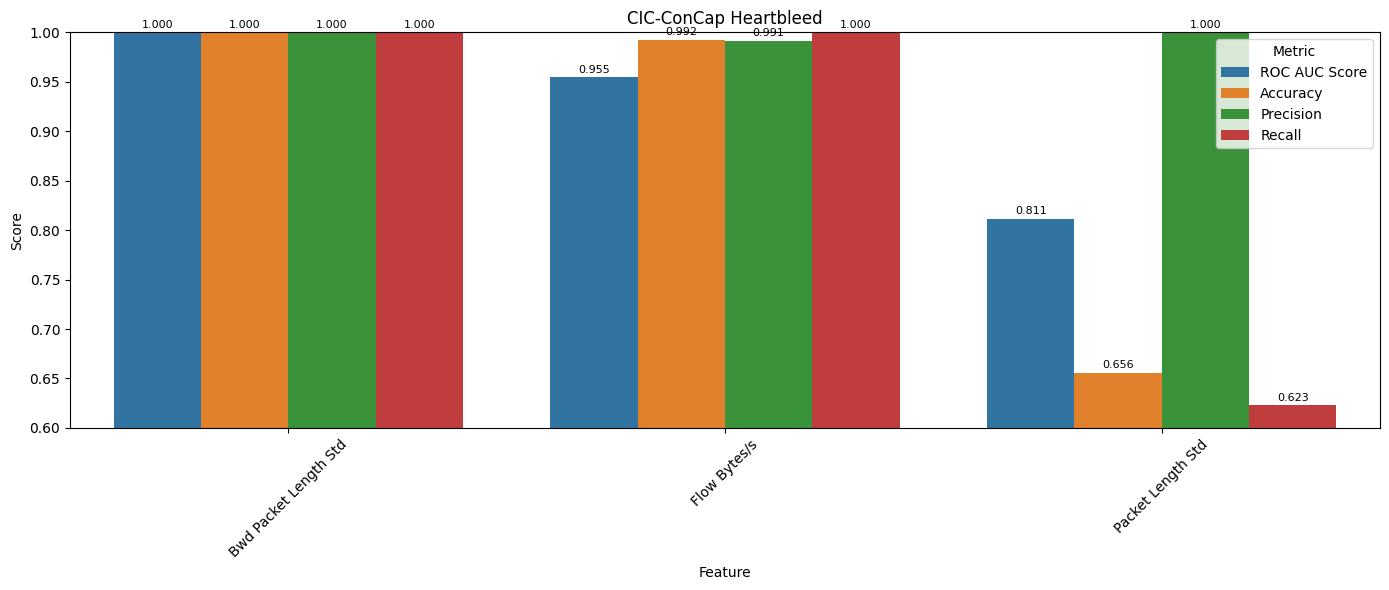

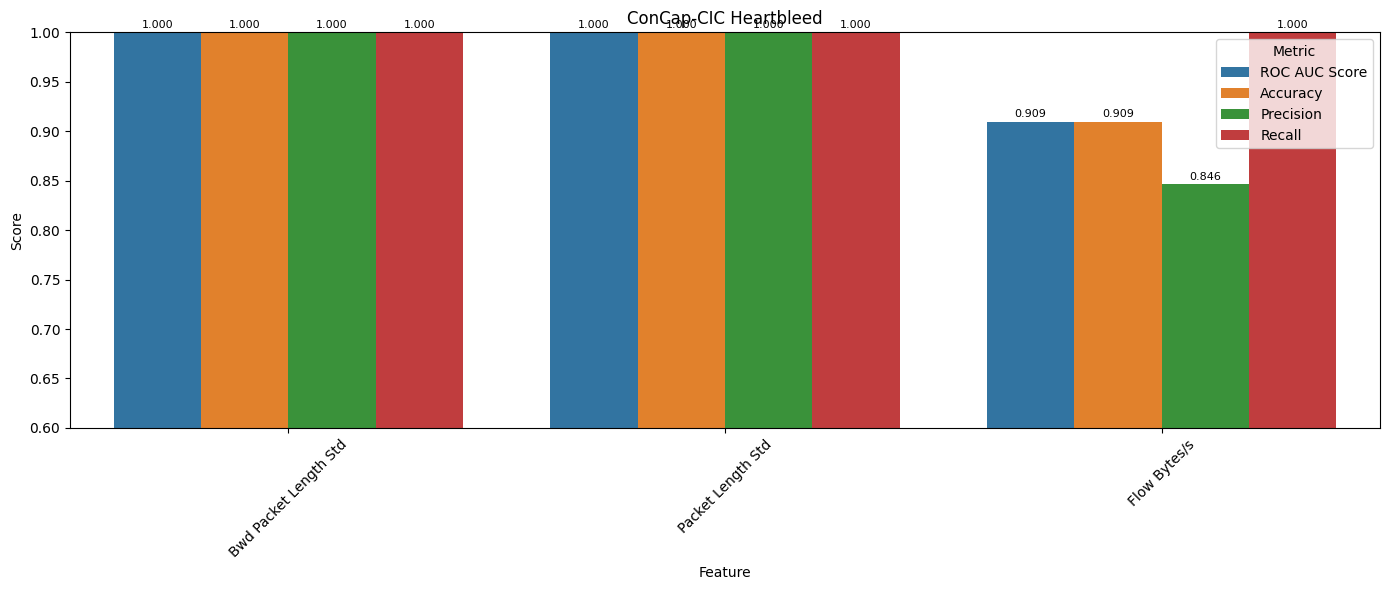

In [55]:
features = get_best_features(cic_concap, concap_cic, .79)
visualize(cic_concap, features, "CIC-ConCap Heartbleed", y_min=.6)
visualize(concap_cic, features, "ConCap-CIC Heartbleed", y_min=.6)

In [56]:
compute_average(features, cic_concap, concap_cic)

,Feature,Average ROC AUC Score
0,Bwd Packet Length Std,1.000000
1,Flow Bytes/s,0.931818
2,Packet Length Std,0.905702


# Thursday

In [102]:
thursday_cic = get_cic_dataset("thursday.csv")
thursday_cic["Label"].unique()

/tmp/ipykernel_5027/1591481594.py:21: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


['BENIGN', 'Web Attack - Brute Force - Attempted', 'Web Attack - Brute Force', 'Infiltration - Attempted', 'Infiltration', 'Infiltration - Portscan', 'Web Attack - XSS - Attempted', 'Web Attack - XSS', 'Web Attack - SQL Injection - Attempted', 'Web Attack - SQL Injection']
Categories (10, object): ['BENIGN', 'Infiltration', 'Infiltration - Attempted', 'Infiltration - Portscan', ..., 'Web Attack - SQL Injection', 'Web Attack - SQL Injection - Attempted', 'Web Attack - XSS', 'Web Attack - XSS - Attempted']

## Web Attack - Bruteforce

In [103]:
cic_bruteforce = thursday_cic[thursday_cic["Label"] == "Web Attack - Brute Force"].copy()
cic_bruteforce["Label"] = 1
cic_bruteforce

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
23096,6,35253111,204,105,43906,72181,602,0,215.225494,228.432175,...,0,0,0.0,0.0,0,0,-1,-1,35253111,1
101853,6,32925619,204,105,43951,72198,602,0,215.446075,228.590454,...,0,0,0.0,0.0,0,0,-1,-1,32925619,1
106815,6,33028450,204,105,43951,72194,602,0,215.446075,228.590454,...,0,0,0.0,0.0,0,0,-1,-1,33028450,1
106897,6,33347965,204,105,43951,72202,602,0,215.446075,228.590454,...,0,0,0.0,0.0,0,0,-1,-1,33347965,1
114783,6,34212507,204,105,43951,72194,602,0,215.446075,228.590454,...,0,0,0.0,0.0,0,0,-1,-1,34212507,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271329,6,34000093,204,105,43906,72186,602,0,215.225494,228.432175,...,0,0,0.0,0.0,0,0,-1,-1,34000093,1
275773,6,34282481,204,107,43951,72189,602,0,215.446075,228.590454,...,0,0,0.0,0.0,0,0,-1,-1,34282481,1
278293,6,34048558,204,105,43906,72188,602,0,215.225494,228.432175,...,0,0,0.0,0.0,0,0,-1,-1,34048558,1
278331,6,33954481,204,105,43906,72180,602,0,215.225494,228.432175,...,0,0,0.0,0.0,0,0,-1,-1,33954481,1


In [104]:
concap_bruteforce = get_concap_dataset("concap_web_bruteforce.csv")
concap_bruteforce

/tmp/ipykernel_5027/1591481594.py:34: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,936259,4,2,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,-1,-1,936259,1
1,6,1053085,4,2,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,-1,-1,1053085,1
2,6,1029193,4,2,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,-1,-1,1029193,1
3,6,1013865,4,2,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,-1,-1,1013865,1
4,6,1071168,17,11,3094.0,14735.0,638.0,0.0,182.000000,231.709137,...,0,0,0,0,0,0,-1,-1,1071168,1
5,6,1011581,4,2,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,-1,-1,1011581,1
6,6,1270632,18,11,3095.0,14739.0,639.0,0.0,171.944443,228.967361,...,0,0,0,0,0,0,-1,-1,1270632,1
7,6,1266643,17,11,3094.0,14736.0,638.0,0.0,182.000000,231.709137,...,0,0,0,0,0,0,-1,-1,1266643,1
8,6,1338306,17,12,3093.0,14737.0,637.0,0.0,181.941177,231.586227,...,0,0,0,0,0,0,-1,-1,1338306,1
9,6,1135702,17,12,3092.0,14735.0,636.0,0.0,181.882355,231.463516,...,0,0,0,0,0,0,-1,-1,1135702,1


In [105]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_bruteforce, concap_bruteforce)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [106]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
70,Fwd Seg Size Min,0.931507,0.902913,0.750000,1.0
67,FWD Init Win Bytes,0.897260,0.854369,0.666667,1.0
24,Fwd IAT Min,0.852055,0.873786,0.774194,0.8
45,FIN Flag Count,0.815068,0.737864,0.526316,1.0
46,SYN Flag Count,0.801370,0.718447,0.508475,1.0
40,Packet Length Min,0.801370,0.718447,0.508475,1.0
0,Protocol,0.801370,0.718447,0.508475,1.0
7,Fwd Packet Length Min,0.801370,0.718447,0.508475,1.0
11,Bwd Packet Length Min,0.794521,0.708738,0.500000,1.0
8,Fwd Packet Length Mean,0.736301,0.834951,0.882353,0.5


In [107]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
4,Total Length of Fwd Packet,1.000000,1.000000,1.000000,1.0
5,Total Length of Bwd Packet,0.993151,0.993151,0.986486,1.0
36,Fwd Header Length,0.993151,0.993151,0.986486,1.0
8,Fwd Packet Length Mean,0.986301,0.986301,0.973333,1.0
55,Fwd Segment Size Avg,0.986301,0.986301,0.973333,1.0
64,Subflow Fwd Bytes,0.986301,0.986301,0.973333,1.0
30,Fwd PSH Flags,0.965753,0.965753,0.935897,1.0
48,PSH Flag Count,0.965753,0.965753,0.935897,1.0
31,Bwd PSH Flags,0.965753,0.965753,0.935897,1.0
69,Fwd Act Data Pkts,0.952055,0.952055,0.912500,1.0


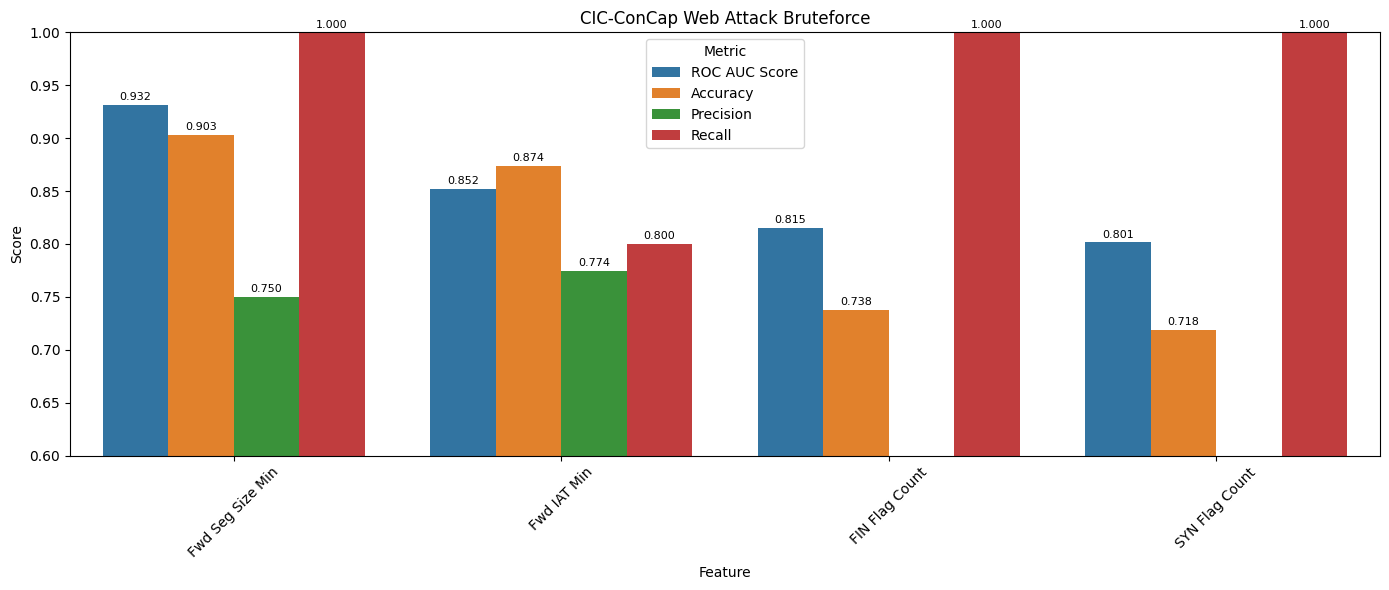

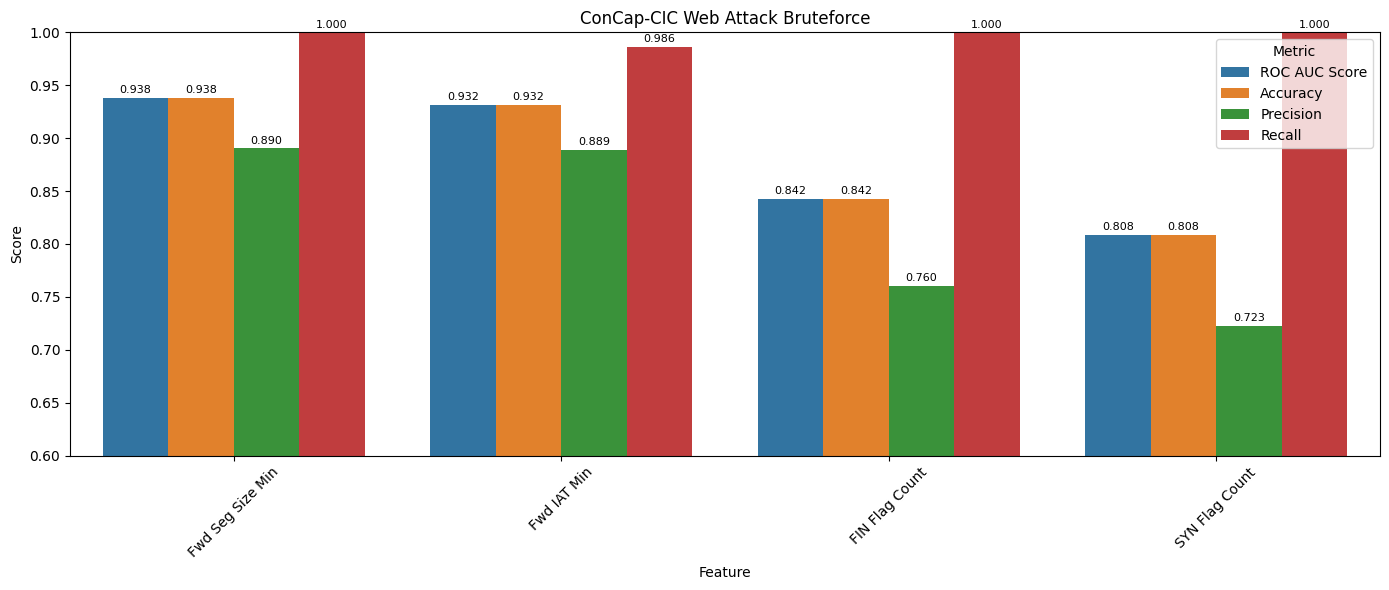

In [108]:
features = get_best_features(cic_concap, concap_cic, .79)
visualize(cic_concap, features, "CIC-ConCap Web Attack Bruteforce", y_min=.6)
visualize(concap_cic, features, "ConCap-CIC Web Attack Bruteforce", y_min=.6)

In [109]:
compute_average(features, cic_concap, concap_cic)

,Feature,Average ROC AUC Score
3,Fwd Seg Size Min,0.934932
1,Fwd IAT Min,0.891781
0,FIN Flag Count,0.828767
2,SYN Flag Count,0.804795


## Web Attack - SQL Injection

In [110]:
cic_sqli = thursday_cic[thursday_cic["Label"] == "Web Attack - SQL Injection"].copy()
cic_sqli["Label"] = 1
cic_sqli

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
111655,6,5039303,5,5,537,1881,537,0,107.400002,240.153702,...,34275,34275,5004343.0,0.0,5004343,5004343,-1,-1,5039303,1
114919,6,5013185,7,5,600,4149,600,0,85.714287,226.778687,...,12319,12319,5000160.0,0.0,5000160,5000160,-1,-1,5013185,1
143118,6,5006123,6,4,599,2021,599,0,99.833336,244.540726,...,5243,5243,5000145.0,0.0,5000145,5000145,-1,-1,5006123,1
149429,6,5087203,6,5,600,4149,600,0,100.000000,244.948975,...,82611,82611,5003905.0,0.0,5003905,5003905,-1,-1,5087203,1
180850,6,5017466,6,6,599,4149,599,0,99.833336,244.540726,...,12710,12710,5004049.0,0.0,5004049,5004049,-1,-1,5017466,1
191985,6,5009656,5,5,599,2021,599,0,119.800003,267.880951,...,5358,5358,5003805.0,0.0,5003805,5003805,-1,-1,5009656,1
192082,6,5006730,5,5,599,2021,599,0,119.800003,267.880951,...,6119,6119,5000049.0,0.0,5000049,5000049,-1,-1,5006730,1
193293,6,5006912,6,5,447,530,447,0,74.500000,182.486984,...,5712,5712,5000415.0,0.0,5000415,5000415,-1,-1,5006912,1
226683,6,5009699,5,5,523,530,523,0,104.599998,233.892715,...,4355,4355,5004686.0,0.0,5004686,5004686,-1,-1,5009699,1
250241,6,5008202,6,4,537,1881,537,0,89.500000,219.229340,...,6787,6787,5000673.0,0.0,5000673,5000673,-1,-1,5008202,1


In [111]:
concap_sqli = get_concap_dataset("concap_sqli.csv")
concap_sqli

/tmp/ipykernel_5027/1591481594.py:34: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,735260,4,2,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,-1,-1,735260,1
1,6,716404,6,5,362.0,626.0,362.0,0.0,60.333332,147.785889,...,0,0,0,0,0,0,-1,-1,716404,1
2,6,730720,4,2,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,-1,-1,730720,1
3,6,1265259,24,16,4763.0,25613.0,637.0,0.0,198.458328,226.531311,...,0,0,0,0,0,0,-1,-1,1265259,1
4,6,1518936,23,14,4401.0,24988.0,637.0,0.0,191.347824,228.867691,...,0,0,0,0,0,0,-1,-1,1518936,1
5,6,1243858,23,15,4327.0,20284.0,637.0,0.0,188.130432,225.771271,...,0,0,0,0,0,0,-1,-1,1243858,1
6,6,1382614,23,14,4401.0,24990.0,637.0,0.0,191.347824,228.867691,...,0,0,0,0,0,0,-1,-1,1382614,1
7,6,1146110,6,4,366.0,816.0,366.0,0.0,61.000000,149.418869,...,0,0,0,0,0,0,-1,-1,1146110,1
8,6,1119428,8,6,802.0,6146.0,436.0,0.0,100.250000,186.567307,...,0,0,0,0,0,0,-1,-1,1119428,1
9,6,716907,6,4,362.0,626.0,362.0,0.0,60.333332,147.785889,...,0,0,0,0,0,0,-1,-1,716907,1


In [112]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_sqli, concap_sqli)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [113]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
53,Down/Up Ratio,0.941130,0.951613,0.979167,0.959184
68,Bwd Init Win Bytes,0.884615,0.951613,0.942308,1.000000
70,Fwd Seg Size Min,0.846154,0.935484,0.924528,1.000000
45,FIN Flag Count,0.846154,0.935484,0.924528,1.000000
29,Bwd IAT Min,0.825746,0.903226,0.921569,0.959184
67,FWD Init Win Bytes,0.807692,0.919355,0.907407,1.000000
11,Bwd Packet Length Min,0.769231,0.903226,0.890909,1.000000
7,Fwd Packet Length Min,0.769231,0.903226,0.890909,1.000000
0,Protocol,0.769231,0.903226,0.890909,1.000000
49,ACK Flag Count,0.769231,0.903226,0.890909,1.000000


In [114]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
10,Bwd Packet Length Max,0.923077,0.923077,0.866667,1.000000
5,Total Length of Bwd Packet,0.923077,0.923077,0.866667,1.000000
70,Fwd Seg Size Min,0.923077,0.923077,0.866667,1.000000
13,Bwd Packet Length Std,0.884615,0.884615,0.916667,0.846154
43,Packet Length Std,0.884615,0.884615,0.857143,0.923077
44,Packet Length Variance,0.884615,0.884615,0.857143,0.923077
4,Total Length of Fwd Packet,0.884615,0.884615,0.812500,1.000000
8,Fwd Packet Length Mean,0.884615,0.884615,0.812500,1.000000
9,Fwd Packet Length Std,0.884615,0.884615,0.812500,1.000000
3,Total Bwd packets,0.884615,0.884615,0.812500,1.000000


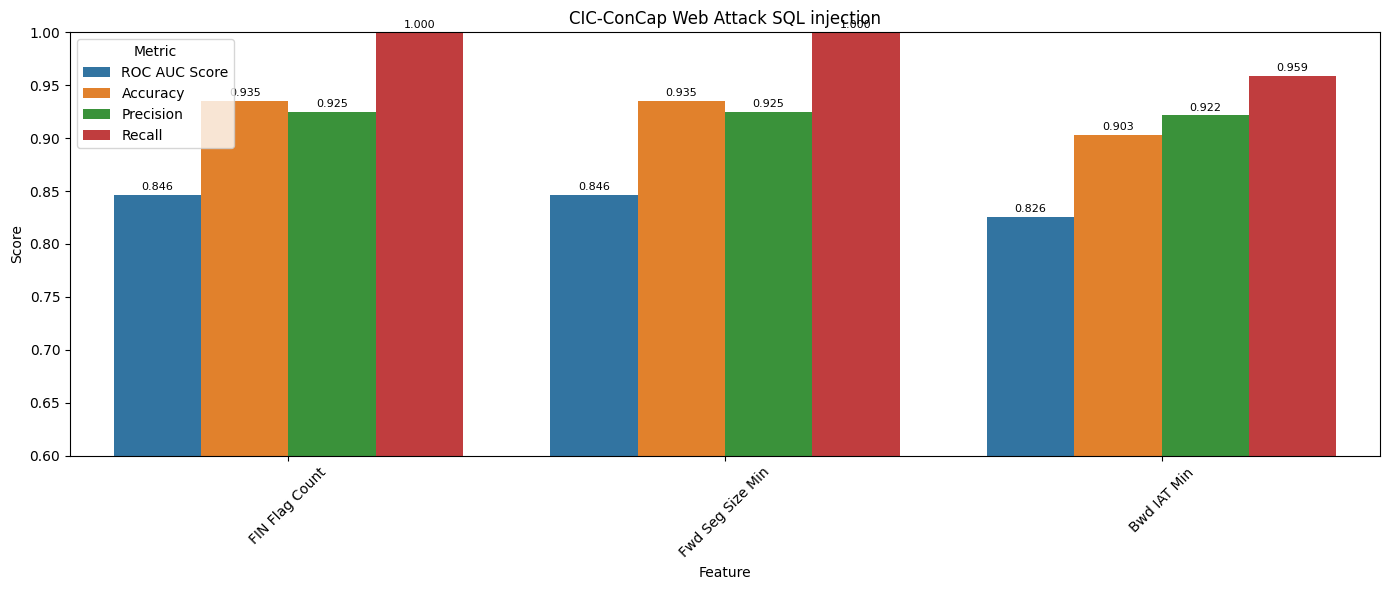

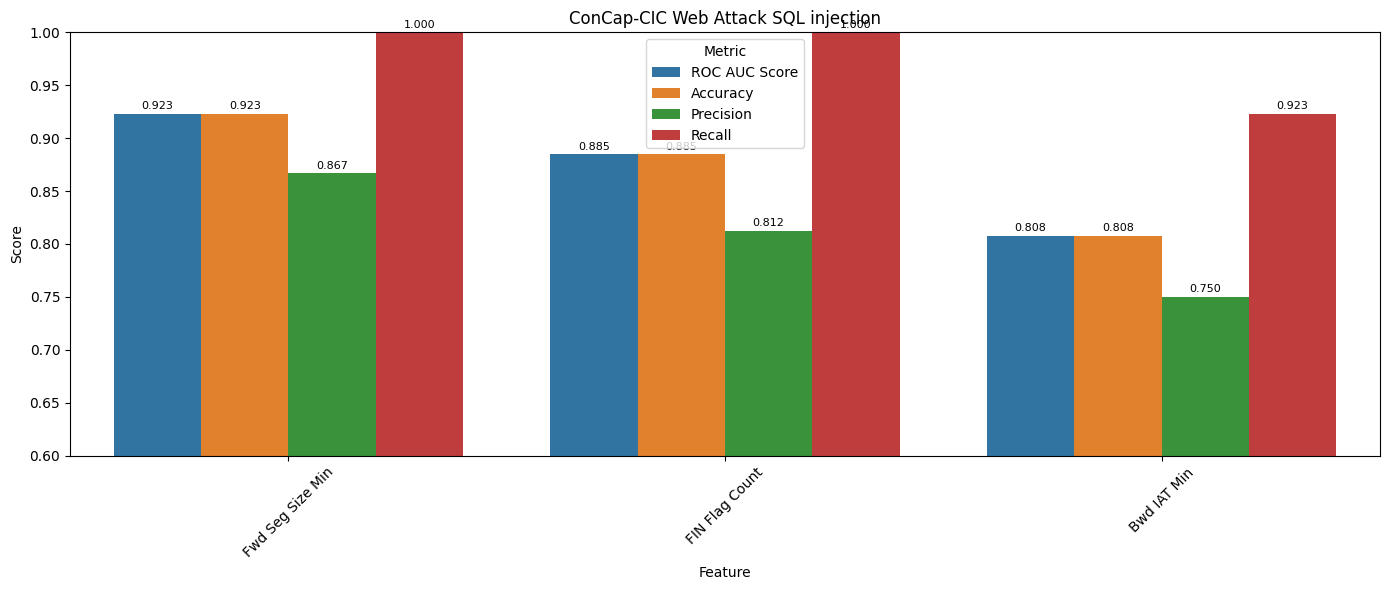

In [115]:
features = get_best_features(cic_concap, concap_cic, .8)
visualize(cic_concap, features, "CIC-ConCap Web Attack SQL injection", y_min=.6)
visualize(concap_cic, features, "ConCap-CIC Web Attack SQL injection", y_min=.6)

In [116]:
compute_average(features, cic_concap, concap_cic)

,Feature,Average ROC AUC Score
2,Fwd Seg Size Min,0.884615
0,FIN Flag Count,0.865385
1,Bwd IAT Min,0.816719


## Web Attack - Cross-Site Scripting

In [117]:
cic_xss = thursday_cic[thursday_cic["Label"] == "Web Attack - XSS"].copy()
cic_xss["Label"] = 1
cic_xss

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
99032,6,60170367,208,107,47903,183657,585,0,230.302887,248.360413,...,0,0,0.0,0.0,0,0,-1,-1,60170367,1
103460,6,69374569,206,105,48783,183572,585,0,236.810684,252.210266,...,0,0,0.0,0.0,0,0,-1,-1,69374569,1
107100,6,69422816,206,110,48783,183586,585,0,236.810684,252.210266,...,0,0,0.0,0.0,0,0,-1,-1,69422816,1
108424,6,67553643,205,105,48985,183689,585,0,238.951218,253.242691,...,0,0,0.0,0.0,0,0,-1,-1,67553643,1
117578,6,68116521,205,105,48985,183692,585,0,238.951218,253.242691,...,0,0,0.0,0.0,0,0,-1,-1,68116521,1
123326,6,66976121,205,106,48783,183586,585,0,237.965851,252.280777,...,0,0,0.0,0.0,0,0,-1,-1,66976121,1
133712,6,68151611,205,115,48783,183606,585,0,237.965851,252.280777,...,0,0,0.0,0.0,0,0,-1,-1,68151611,1
134185,6,68065237,214,107,48783,183584,585,0,227.957947,251.492416,...,0,0,0.0,0.0,0,0,-1,-1,68065237,1
146833,6,67291468,210,105,48985,183697,585,0,233.261902,252.845917,...,0,0,0.0,0.0,0,0,-1,-1,67291468,1
148732,6,67053821,206,105,48985,183687,585,0,237.791260,253.172256,...,0,0,0.0,0.0,0,0,-1,-1,67053821,1


In [118]:
concap_xss = get_concap_dataset("concap_xss.csv")
concap_xss

/tmp/ipykernel_5027/1591481594.py:34: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,1677330,25,17,4789.0,25649.0,643.0,0.0,191.559998,226.390900,...,0,0,0,0,0,0,-1,-1,1677330,1
1,6,1454394,8,5,810.0,6146.0,440.0,0.0,101.250000,188.409698,...,0,0,0,0,0,0,-1,-1,1454394,1
2,6,1372682,8,6,810.0,6146.0,440.0,0.0,101.250000,188.409698,...,0,0,0,0,0,0,-1,-1,1372682,1
3,6,1266452,8,6,810.0,6146.0,440.0,0.0,101.250000,188.409698,...,0,0,0,0,0,0,-1,-1,1266452,1
4,6,1374229,23,15,4349.0,20320.0,643.0,0.0,189.086960,226.786819,...,0,0,0,0,0,0,-1,-1,1374229,1
5,6,1206963,22,15,4349.0,20320.0,643.0,0.0,197.681824,228.257462,...,0,0,0,0,0,0,-1,-1,1206963,1
6,6,1608135,23,15,4349.0,20321.0,643.0,0.0,189.086960,226.786819,...,0,0,0,0,0,0,-1,-1,1608135,1
7,6,771588,6,4,366.0,626.0,366.0,0.0,61.000000,149.418869,...,0,0,0,0,0,0,-1,-1,771588,1
8,6,726686,6,4,366.0,626.0,366.0,0.0,61.000000,149.418869,...,0,0,0,0,0,0,-1,-1,726686,1
9,6,1482666,21,14,3983.0,19695.0,643.0,0.0,189.666672,230.700089,...,0,0,0,0,0,0,-1,-1,1482666,1


In [119]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_xss, concap_xss)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [120]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
67,FWD Init Win Bytes,0.916667,0.954545,0.941176,1.000000
70,Fwd Seg Size Min,0.888889,0.939394,0.923077,1.000000
13,Bwd Packet Length Std,0.850694,0.833333,0.951220,0.812500
46,SYN Flag Count,0.805556,0.893939,0.872727,1.000000
44,Packet Length Variance,0.802083,0.712121,1.000000,0.604167
41,Packet Length Max,0.802083,0.712121,1.000000,0.604167
43,Packet Length Std,0.802083,0.712121,1.000000,0.604167
10,Bwd Packet Length Max,0.802083,0.712121,1.000000,0.604167
24,Fwd IAT Min,0.795139,0.803030,0.906977,0.812500
66,Subflow Bwd Bytes,0.791667,0.696970,1.000000,0.583333


In [121]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
70,Fwd Seg Size Min,0.972222,0.972222,0.947368,1.0
68,Bwd Init Win Bytes,0.972222,0.972222,0.947368,1.0
55,Fwd Segment Size Avg,0.944444,0.944444,0.900000,1.0
64,Subflow Fwd Bytes,0.944444,0.944444,0.900000,1.0
9,Fwd Packet Length Std,0.944444,0.944444,0.900000,1.0
8,Fwd Packet Length Mean,0.944444,0.944444,0.900000,1.0
4,Total Length of Fwd Packet,0.916667,0.916667,0.857143,1.0
6,Fwd Packet Length Max,0.916667,0.916667,0.857143,1.0
13,Bwd Packet Length Std,0.888889,0.888889,0.818182,1.0
10,Bwd Packet Length Max,0.888889,0.888889,0.818182,1.0


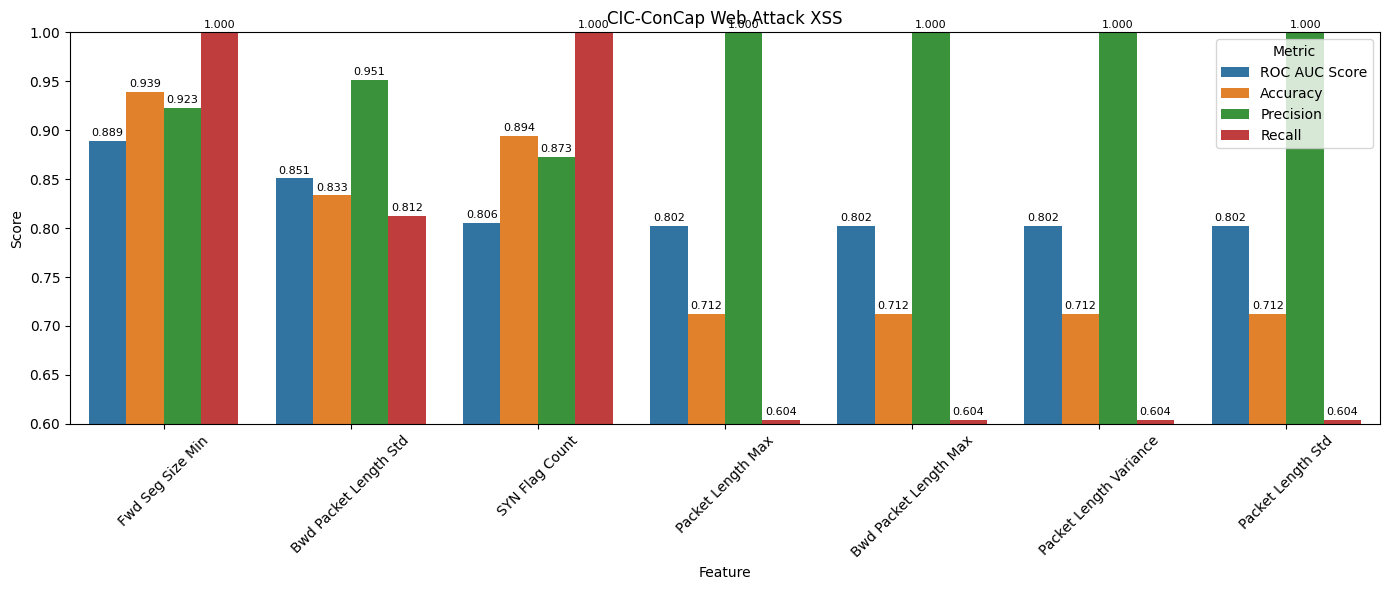

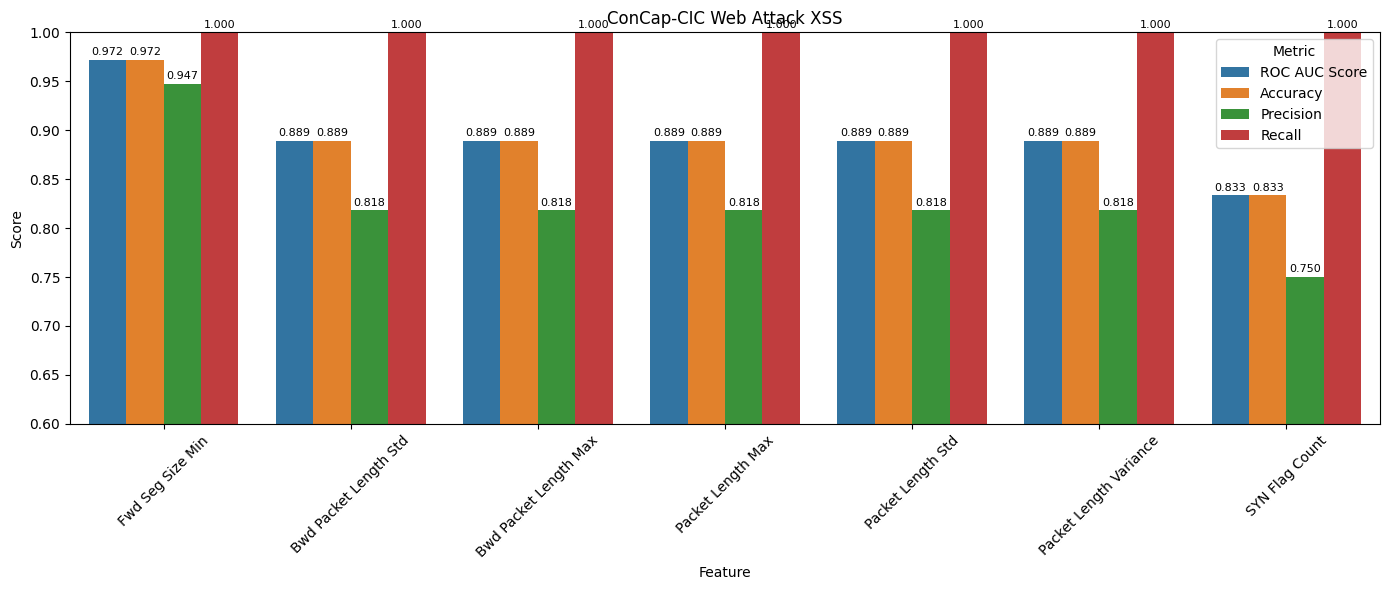

In [122]:
features = get_best_features(cic_concap, concap_cic, .79)
visualize(cic_concap, features, "CIC-ConCap Web Attack XSS", y_min=.6)
visualize(concap_cic, features, "ConCap-CIC Web Attack XSS", y_min=.6)

In [123]:
compute_average(features, cic_concap, concap_cic)

,Feature,Average ROC AUC Score
3,Fwd Seg Size Min,0.930556
0,Bwd Packet Length Std,0.869792
1,Packet Length Max,0.845486
2,Packet Length Variance,0.845486
5,Bwd Packet Length Max,0.845486
6,Packet Length Std,0.845486
4,SYN Flag Count,0.819444


# Friday

In [124]:
friday_cic = get_cic_dataset("friday.csv")

/tmp/ipykernel_5027/1591481594.py:21: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [125]:
friday_cic["Label"].unique()

['BENIGN', 'Botnet - Attempted', 'Botnet', 'Portscan', 'DDoS']
Categories (5, object): ['BENIGN', 'Botnet', 'Botnet - Attempted', 'DDoS', 'Portscan']

## LOIC

In [126]:
cic_loic = friday_cic[friday_cic["Label"] == "DDoS"].copy()
cic_loic["Label"] = 1
cic_loic

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
82519,6,9157589,8,6,20,11595,20,0,2.500000,7.071068,...,1084925,1084925,8072664.0,0.0,8072664,8072664,-1,-1,9157589,1
82520,6,6150288,8,6,20,11595,20,0,2.500000,7.071068,...,407765,407765,5742523.0,0.0,5742523,5742523,-1,-1,6150288,1
82521,6,8410717,8,6,20,11595,20,0,2.500000,7.071068,...,644213,644213,7766504.0,0.0,7766504,7766504,-1,-1,8410717,1
82523,6,7757913,8,5,20,11595,20,0,2.500000,7.071068,...,683993,683993,7073920.0,0.0,7073920,7073920,-1,-1,7757913,1
82524,6,8063397,8,6,20,11595,20,0,2.500000,7.071068,...,307905,307905,7755492.0,0.0,7755492,7755492,-1,-1,8063397,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370340,6,8809229,8,5,20,11595,20,0,2.500000,7.071068,...,708296,708296,8100933.0,0.0,8100933,8100933,-1,-1,8809229,1
370347,6,5746903,8,4,20,11595,20,0,2.500000,7.071068,...,0,0,0.0,0.0,0,0,-1,-1,5746903,1
370363,6,3966857,8,4,20,11595,20,0,2.500000,7.071068,...,0,0,0.0,0.0,0,0,-1,-1,3966857,1
370364,6,11276716,9,5,20,11595,20,0,2.222222,6.666667,...,113023,113023,11163693.0,0.0,11163693,11163693,-1,-1,11276716,1


In [127]:
concap_loic = get_concap_dataset("concap_loic.csv")
concap_loic.drop(columns=["target", "port", "service"], inplace=True, errors='ignore')
concap_loic

/tmp/ipykernel_5027/1591481594.py:34: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,31064,11,9,131.0,11574.0,131.0,0.0,11.909091,39.497986,...,0,0,0,0,0,0,-1,-1,31064,1
1,6,21147,10,8,131.0,11574.0,131.0,0.0,13.100000,41.425838,...,0,0,0,0,0,0,-1,-1,21147,1
2,6,20759,10,8,138.0,11574.0,138.0,0.0,13.800000,43.639431,...,0,0,0,0,0,0,-1,-1,20759,1
3,6,21115,10,8,138.0,11574.0,138.0,0.0,13.800000,43.639431,...,0,0,0,0,0,0,-1,-1,21115,1
4,6,20847,10,8,131.0,11574.0,131.0,0.0,13.100000,41.425838,...,0,0,0,0,0,0,-1,-1,20847,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33876,6,21435,10,8,132.0,11574.0,132.0,0.0,13.200000,41.742065,...,0,0,0,0,0,0,-1,-1,21435,1
33877,6,21625,10,8,138.0,11574.0,138.0,0.0,13.800000,43.639431,...,0,0,0,0,0,0,-1,-1,21625,1
33878,6,21474,10,8,131.0,11574.0,131.0,0.0,13.100000,41.425838,...,0,0,0,0,0,0,-1,-1,21474,1
33879,6,22083,10,8,138.0,11574.0,138.0,0.0,13.800000,43.639431,...,0,0,0,0,0,0,-1,-1,22083,1


In [128]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_bruteforce, concap_bruteforce)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [129]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
70,Fwd Seg Size Min,0.931507,0.902913,0.750000,1.0
67,FWD Init Win Bytes,0.910959,0.873786,0.697674,1.0
46,SYN Flag Count,0.842466,0.776699,0.566038,1.0
24,Fwd IAT Min,0.838356,0.854369,0.727273,0.8
45,FIN Flag Count,0.828767,0.757282,0.545455,1.0
40,Packet Length Min,0.815068,0.737864,0.526316,1.0
11,Bwd Packet Length Min,0.815068,0.737864,0.526316,1.0
7,Fwd Packet Length Min,0.815068,0.737864,0.526316,1.0
0,Protocol,0.815068,0.737864,0.526316,1.0
19,Flow IAT Min,0.794521,0.708738,0.500000,1.0


In [130]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
8,Fwd Packet Length Mean,0.972603,0.972603,0.948052,1.000000
4,Total Length of Fwd Packet,0.972603,0.972603,0.948052,1.000000
55,Fwd Segment Size Avg,0.972603,0.972603,0.948052,1.000000
64,Subflow Fwd Bytes,0.972603,0.972603,0.948052,1.000000
48,PSH Flag Count,0.972603,0.972603,0.948052,1.000000
31,Bwd PSH Flags,0.972603,0.972603,0.948052,1.000000
30,Fwd PSH Flags,0.965753,0.965753,0.935897,1.000000
69,Fwd Act Data Pkts,0.958904,0.958904,0.924051,1.000000
68,Bwd Init Win Bytes,0.945205,0.945205,0.911392,0.986301
53,Down/Up Ratio,0.938356,0.938356,0.890244,1.000000


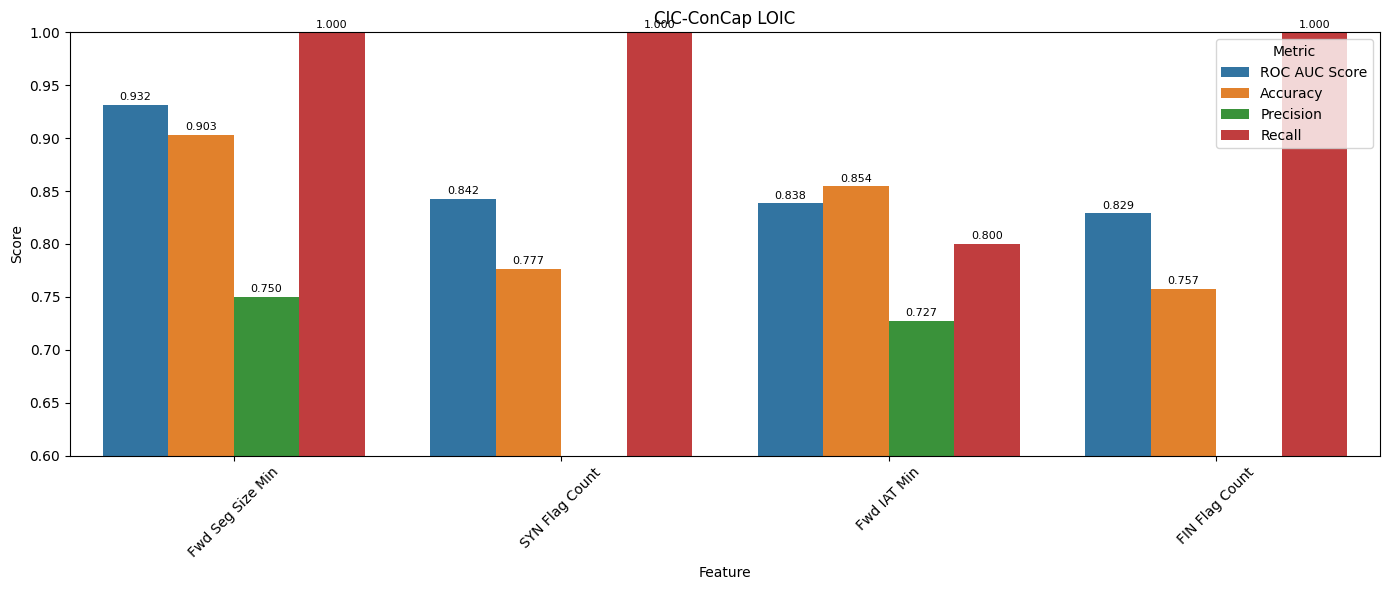

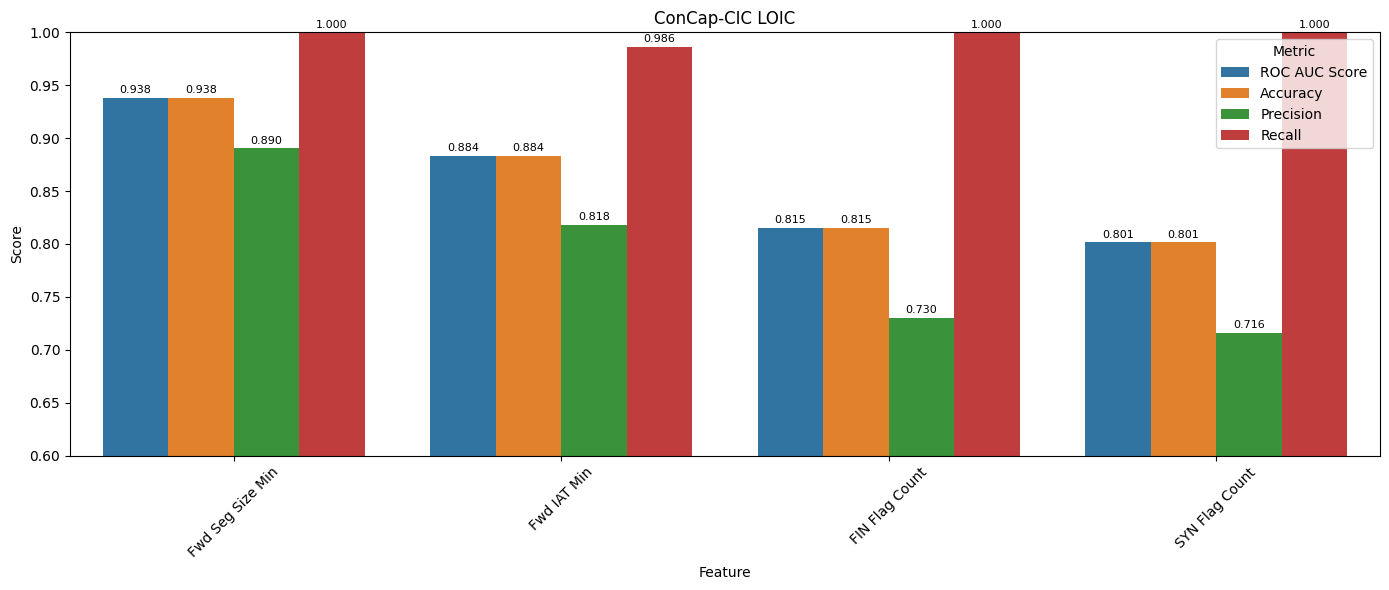

In [131]:
features = get_best_features(cic_concap, concap_cic, .79)
visualize(cic_concap, features, "CIC-ConCap LOIC", y_min=.6)
visualize(concap_cic, features, "ConCap-CIC LOIC", y_min=.6)

In [132]:
compute_average(features, cic_concap, concap_cic)

,Feature,Average ROC AUC Score
3,Fwd Seg Size Min,0.934932
1,Fwd IAT Min,0.860959
0,FIN Flag Count,0.821918
2,SYN Flag Count,0.821918


## Portscan

In [133]:
cic_portscan = friday_cic[friday_cic["Label"] == "Portscan"].copy()
cic_portscan["Label"] = 1
cic_portscan

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
66403,6,44,1,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,44,1
66404,6,43,1,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,43,1
66405,6,54,1,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,54,1
66406,6,33,1,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,33,1
66407,6,50,1,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368745,6,662,2,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,662,1
368962,6,635,2,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,635,1
369063,6,691,2,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,691,1
369283,6,607,2,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,607,1


In [134]:
concap_portscan = get_concap_dataset("concap_portscan.csv")
concap_portscan

/tmp/ipykernel_5027/1591481594.py:34: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,52,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,52,1
1,6,12,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,12,1
2,6,13,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,13,1
3,6,74,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,74,1
4,6,30,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,6,197,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,197,1
598,6,132,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,132,1
599,1,111,2,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,8,0,1
600,1,683,2,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,8,0,1


In [135]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_portscan, concap_portscan)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [136]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
5,Total Length of Bwd Packet,0.960270,0.954048,0.868148,0.973422
10,Bwd Packet Length Max,0.958488,0.951422,0.860499,0.973422
12,Bwd Packet Length Mean,0.958488,0.951422,0.860499,0.973422
56,Bwd Segment Size Avg,0.958488,0.951422,0.860499,0.973422
41,Packet Length Max,0.944908,0.947921,0.873261,0.938538
66,Subflow Bwd Bytes,0.944524,0.930853,0.804945,0.973422
43,Packet Length Std,0.942700,0.939168,0.839941,0.950166
44,Packet Length Variance,0.942700,0.939168,0.839941,0.950166
6,Fwd Packet Length Max,0.938567,0.948796,0.891761,0.916944
4,Total Length of Fwd Packet,0.937203,0.948359,0.892857,0.913621


In [137]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
6,Fwd Packet Length Max,0.960784,0.960784,0.960784,0.960784
8,Fwd Packet Length Mean,0.960487,0.960487,0.960214,0.960784
55,Fwd Segment Size Avg,0.960487,0.960487,0.960214,0.960784
4,Total Length of Fwd Packet,0.960190,0.960190,0.959644,0.960784
64,Subflow Fwd Bytes,0.959893,0.959893,0.959075,0.960784
41,Packet Length Max,0.937908,0.937908,0.947209,0.927510
42,Packet Length Mean,0.937611,0.937611,0.964083,0.909091
54,Average Packet Size,0.937611,0.937611,0.964083,0.909091
66,Subflow Bwd Bytes,0.929293,0.929293,0.947368,0.909091
14,Flow Bytes/s,0.924242,0.924242,0.966057,0.879382


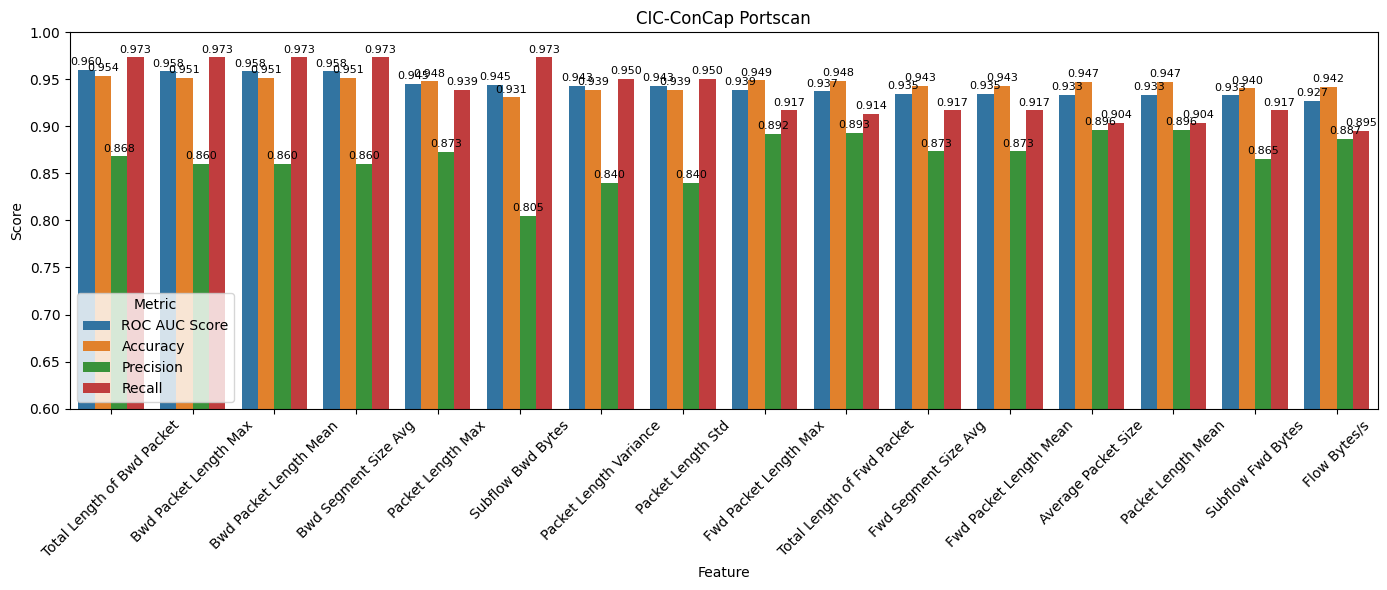

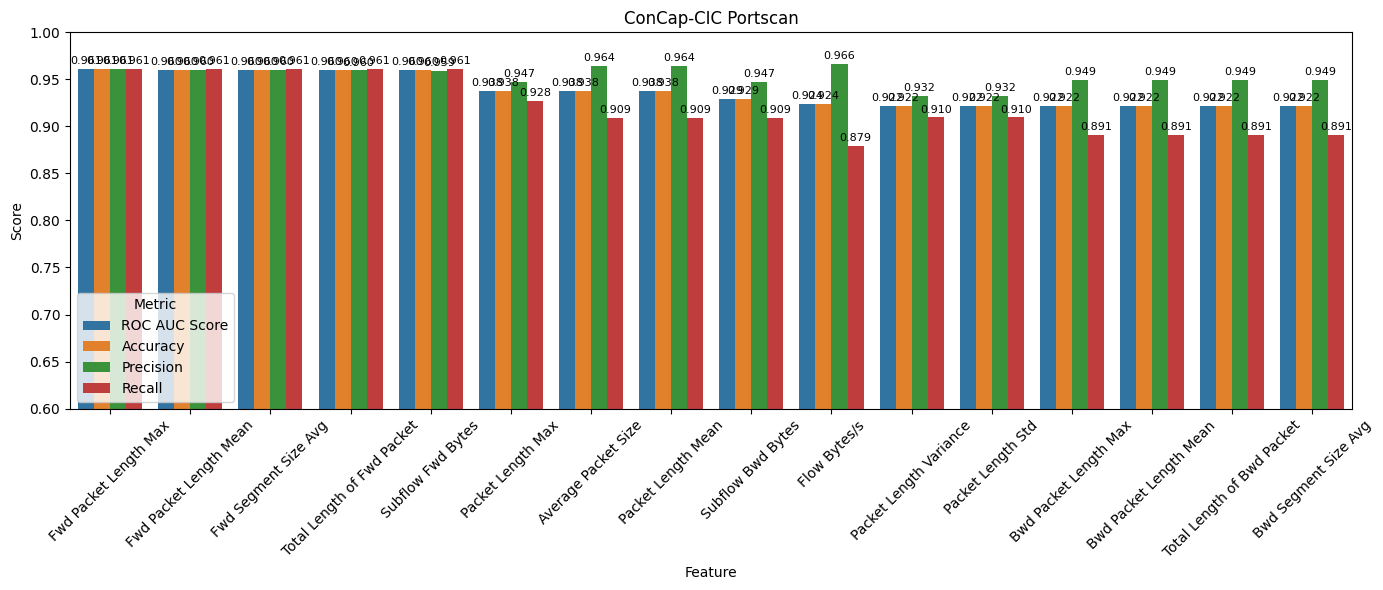

In [138]:
features = get_best_features(cic_concap, concap_cic, .92)
visualize(cic_concap, features, "CIC-ConCap Portscan", y_min=.6)
visualize(concap_cic, features, "ConCap-CIC Portscan", y_min=.6)

In [139]:
compute_average(features, cic_concap, concap_cic)

,Feature,Average ROC AUC Score
0,Fwd Packet Length Max,0.949676
11,Total Length of Fwd Packet,0.948696
13,Fwd Segment Size Avg,0.947596
7,Fwd Packet Length Mean,0.947596
3,Subflow Fwd Bytes,0.946408
5,Packet Length Max,0.941408
12,Total Length of Bwd Packet,0.940919
2,Bwd Segment Size Avg,0.940028
15,Bwd Packet Length Mean,0.940028
10,Bwd Packet Length Max,0.940028
